
--- SDEConvolution Full Reversibility Verification (Unweighted Sum) (9x9 Grid, D=2) ---

Initial Real Input Z_a (first 3 dims): [14.411632537841797, 16.830520629882812]
Final Real Output Y_a (first 3 dims): [14.41161823272705, 16.83050537109375]
Max Absolute Error (|Z_a - Y_a|): 1.525879e-05
Status: FAILURE (Error is higher than expected: 1.53e-05)


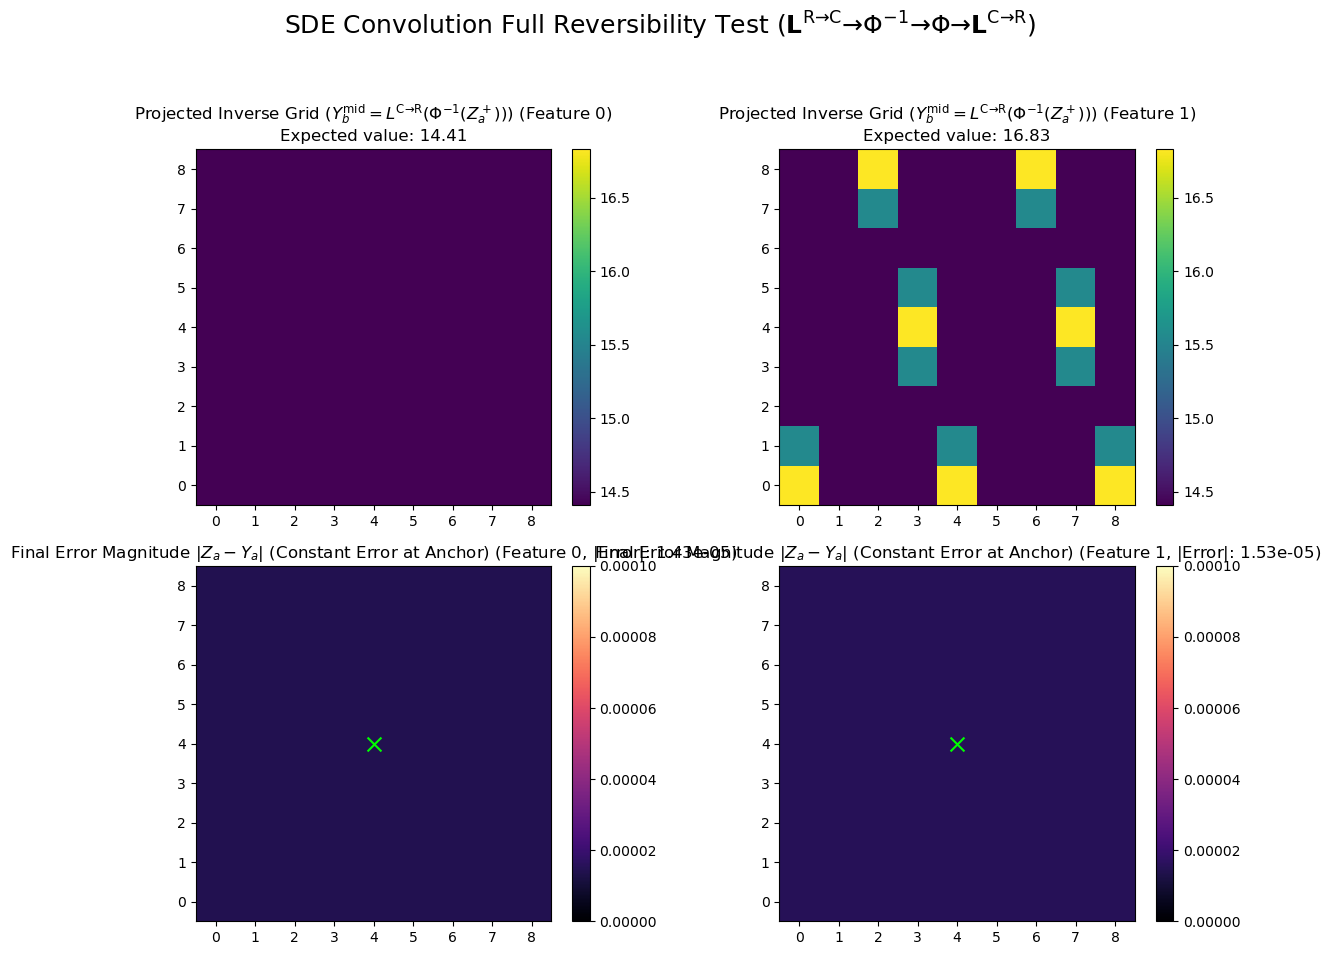


--- Testing FullSDEConv2d Layer with RANDOM Input (K=3, S=1) ---
Input Shape: torch.Size([2, 4, 16, 16])
Output Shape: torch.Size([2, 4, 16, 16])
Input HxW: 16x16, Output HxW: 16x16 (Expected: 16x16, Stride: 1, Padding: 1)
FullSDEConv2d executed successfully.


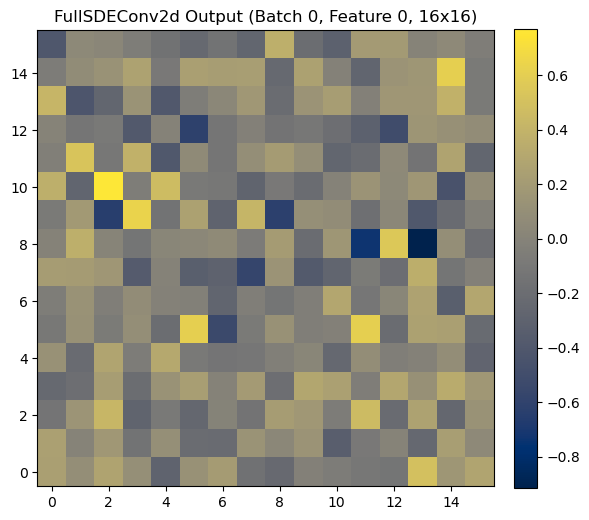


--- Testing FullSDEConv2d Layer with STRUCTURED Input (K=3, S=1) ---
Input Shape: torch.Size([1, 4, 16, 16])
Output Shape: torch.Size([1, 4, 16, 16])


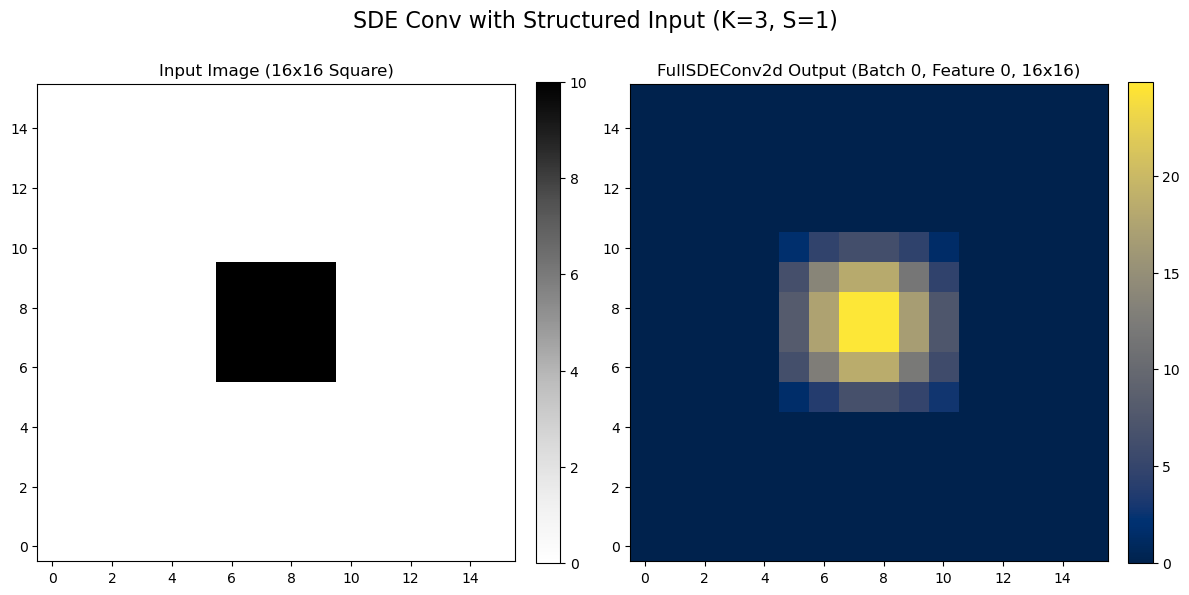


--- Testing FullSDEConv2d Layer with RANDOM Input (K=3, S=2) ---
Input Shape: torch.Size([2, 4, 16, 16])
Output Shape: torch.Size([2, 4, 8, 8])
Input HxW: 16x16, Output HxW: 8x8 (Expected: 8x8, Stride: 2, Padding: 1)
FullSDEConv2d executed successfully.


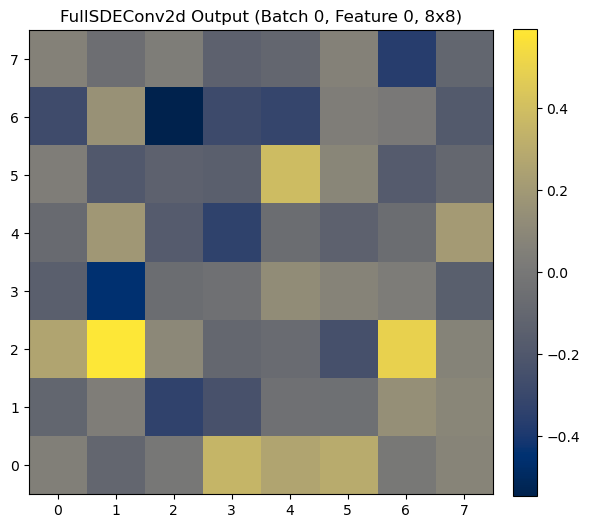


--- Comparing SDE Conv (Kalman Smoother) vs. Standard Conv (Denoising SDE Signal) (K=7) ---


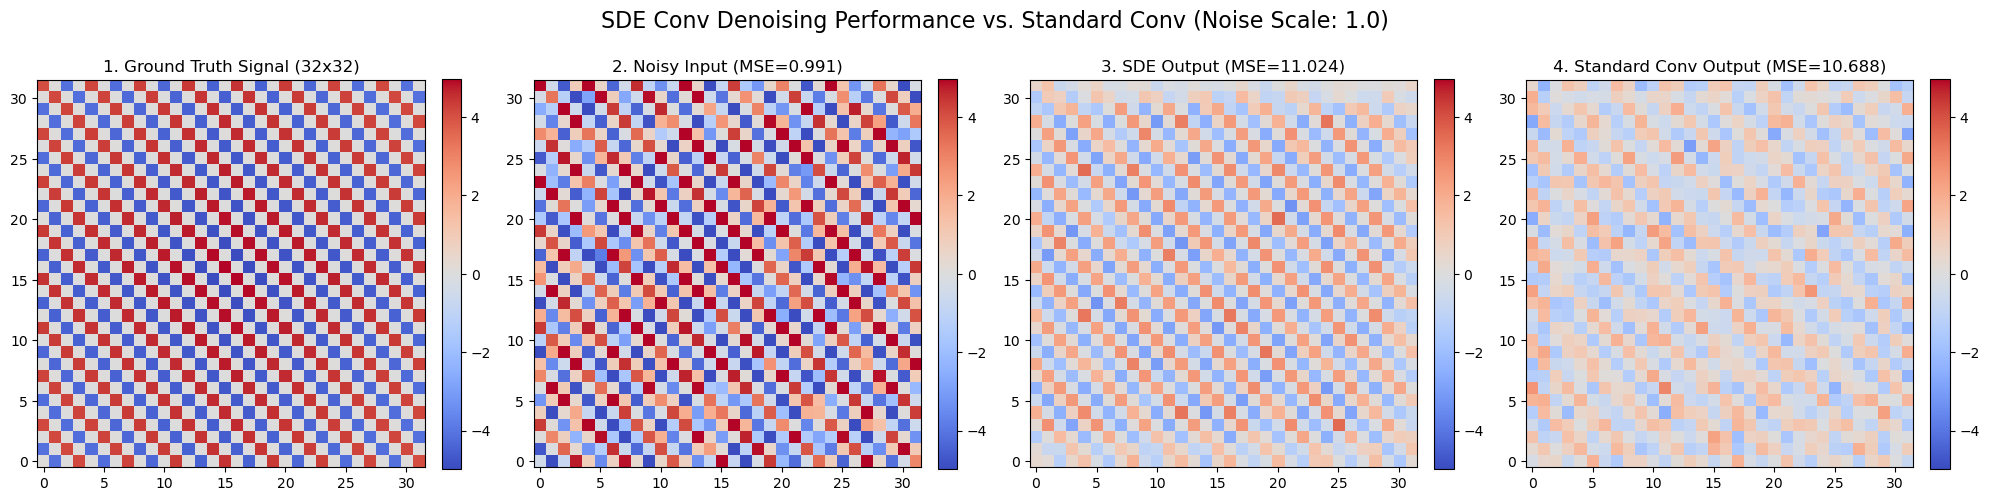


Denoising Test Results:
Initial Noise MSE (Input vs GT): 0.9910
SDE Conv Denoised MSE (Output vs GT): 11.0245
Standard Conv Denoised MSE (Output vs GT): 10.6879
SDE Conv Reduction Factor: 0.09x better than noisy input


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Utility Functions ---

def complex_to_phase_intensity_image(z_r: torch.Tensor, z_i: torch.Tensor) -> np.ndarray:
    """
    Maps a complex tensor (R, I) of shape (N, N) to a single intensity image (N, N)
    based on the Phase (Hue). The phase is normalized to [0, 1] for visualization.
    """
    phase = torch.atan2(z_i, z_r)
    normalized_phase = (phase + math.pi) / (2 * math.pi)
    return normalized_phase.cpu().numpy()

def create_structured_input(H, W, D, square_size=4, value=10.0):
    """Creates a structured input tensor (white square on a black background)."""
    # Create a zero tensor (B=1, D, H, W)
    X = torch.zeros(1, D, H, W)
    
    # Calculate center and boundaries for the square
    h_start = (H - square_size) // 2
    h_end = h_start + square_size
    w_start = (W - square_size) // 2
    w_end = w_start + square_size
    
    # Set the square region to the specified value across all channels
    X[0, :, h_start:h_end, w_start:w_end] = value
    
    return X

def create_gabor_like_input(H, W, D, frequency=3.5, decay_factor=0.3):
    """Creates a directional (sine wave) input with a central Gaussian-like envelope."""
    # Create spatial coordinates
    y_coords, x_coords = torch.meshgrid(torch.arange(H), torch.arange(W), indexing='ij')
    y_norm = (y_coords.float() - H / 2) / (H / 2)
    x_norm = (x_coords.float() - W / 2) / (W / 2)

    # 1. Sine wave (oscillation along the y-axis, creating horizontal stripes)
    sin_wave = torch.sin(2 * math.pi * frequency * y_norm)

    # 2. Gaussian Envelope (central localization)
    gaussian_envelope = torch.exp(-(x_norm**2 + y_norm**2) / (2 * decay_factor**2))
    
    # Combined pattern
    pattern = sin_wave * gaussian_envelope
    
    # Scale and replicate across channels (B=1, D, H, W)
    X = pattern.unsqueeze(0).unsqueeze(0).repeat(1, D, 1, 1)
    
    # Normalize to [-1, 1] for stable feature input
    X = (X - X.min()) / (X.max() - X.min())
    X = X * 2 - 1 
    
    return X

def create_sde_generated_input(H, W, D, alpha_sq, omega_y, noise_scale=0.5):
    """
    Generates a ground-truth feature map based on SDE propagation from the center
    and adds measurement noise.
    
    Returns: X_noisy (B, D, H, W), X_gt (B, D, H, W)
    """
    
    # --- 1. Define SDE Dynamics (Simplified, Isotropic) ---
    # We assume symmetric dynamics and use the parameters for the vertical axis (y) 
    # to create the structure for both axes, for demonstration simplicity.
    
    # alpha_sq is assumed to be a scalar/vector for the feature dimension D
    alpha_sq = alpha_sq.view(1, D) # (1, D)
    omega_y = omega_y.view(1, D)   # (1, D)

    # --- 2. Generate Coordinates ---
    y_coords, x_coords = torch.meshgrid(torch.arange(H), torch.arange(W), indexing='ij')
    x_coords = x_coords.float()
    y_coords = y_coords.float()
    
    center_x = (W - 1) / 2.0
    center_y = (H - 1) / 2.0
    
    # Displacement from anchor (center) to pixel (i,j): Delta P' = P_ij - P_anchor
    # We use Delta P' = P_ij - P_center, so propagation is from the center (P_anchor)
    # to the current pixel (P_b)
    Delta_X_prime = x_coords - center_x # (H, W)
    Delta_Y_prime = y_coords - center_y # (H, W)

    # Delta P: (H, W, 2)
    Delta_P_prime = torch.stack([Delta_X_prime, Delta_Y_prime], dim=-1)

    # --- 3. Compute Propagation Kernel (Phi) from Center to all Pixels ---
    # Note: For generation, we assume a single direction (e.g., L->R and B->T for positive deltas)
    # Since alpha/omega are symmetric here, we don't need quadrant logic for generation.
    
    # Decay Term: exp(-alpha^2 |Delta p'|)
    decay_x = torch.exp(-alpha_sq * torch.abs(Delta_P_prime[..., 0].unsqueeze(-1)))
    decay_y = torch.exp(-alpha_sq * torch.abs(Delta_P_prime[..., 1].unsqueeze(-1)))
    decay_total = decay_x * decay_y # (H, W, D)

    # Phase Term: exp(-i * omega * Delta p')
    theta_xy = (omega_y * Delta_P_prime[..., 0].unsqueeze(-1)) + \
               (omega_y * Delta_P_prime[..., 1].unsqueeze(-1)) # (H, W, D)

    Phi_r = decay_total * torch.cos(theta_xy)      
    Phi_i = decay_total * -torch.sin(theta_xy) 

    # --- 4. Propagate Seed to Create Ground Truth Signal ---
    
    # Initialize a complex seed signal at the center (Na=1)
    Z_seed_r = torch.ones(1, D) * 5.0 # Constant initial state
    Z_seed_i = torch.zeros(1, D) 

    # Z_gt (Complex): (H, W, D)
    Z_gt_r = Phi_r * Z_seed_r # (H, W, D) * (1, D)
    Z_gt_i = Phi_i * Z_seed_i # This term is zero because Z_seed_i is zero
    
    # X_gt (Real): Use the real part as the observed/true real features
    X_gt = Z_gt_r.unsqueeze(0).permute(0, 3, 1, 2) # (1, D, H, W)

    # --- 5. Add Measurement Noise ---
    noise = torch.randn_like(X_gt) * noise_scale
    X_noisy = X_gt + noise
    
    return X_noisy, X_gt, alpha_sq, omega_y


# --- 2. SDE Convolution Helper Classes ---

class RealToComplexLinear(nn.Module):
    """
    Simulates the L^{R->C} layer: X -> Z^+ = X W_r + i X W_i.
    The weights W_r and W_i form a complex matrix A = W_r + i W_i.
    """
    def __init__(self, d_model: int):
        super().__init__()
        self.d_model = d_model
        # Weights for the real and imaginary parts of the complex projection
        self.W_r = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))
        self.W_i = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Input X: (..., D). Output Z_plus: (2, ..., D)"""
        Z_r = X @ self.W_r
        Z_i = X @ self.W_i
        # Stack output: (2, ..., D)
        return torch.stack([Z_r, Z_i], dim=0)

class ComplexToRealLinear(nn.Module):
    """
    Simulates the L^{C->R} layer: Y = Re(Z^+ A^{-1*}), where Z^+ = Z_r + i Z_i
    If A_inv = W_r_inv + i W_i_inv, then Y = Z_r W_r_inv^T - Z_i W_i_inv^T.
    The weights W_r and W_i here should be the real and imaginary parts of A^{-1}.
    """
    def __init__(self, d_model: int):
        super().__init__()
        self.d_model = d_model
        # These weights should be derived from the inverse of the R2C layer's complex weight.
        self.W_r = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))
        self.W_i = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))

    def forward(self, Z_plus: torch.Tensor) -> torch.Tensor:
        """Input Z_plus: (2, ..., D). Output Y: (..., D)"""
        Z_r, Z_i = torch.unbind(Z_plus, dim=0) # (..., D)
        
        # Y = Z_r @ W_r^T - Z_i @ W_i^T (The projection formula)
        Y = (Z_r @ self.W_r.T) - (Z_i @ self.W_i.T)
        return Y

class SpatialCoordinateTransformer(nn.Module):
    """
    Generates relative positions Delta p' for all pairs of anchor (Na) and source (Nb) pixels.
    Returns: torch.Tensor: Relative positions (Na, Nb, 2), where Na=K*K, Nb=K_source*K_source.
    """
    def __init__(self):
        super().__init__()
        pass

    def forward(self, K: int, K_source: int) -> torch.Tensor:
        """
        Generates untransformed relative positions $\Delta \mathbf{p} = \mathbf{p}_a - \mathbf{p}_b$.
        """
        y_coords, x_coords = torch.meshgrid(torch.arange(K_source), torch.arange(K_source), indexing='ij')
        p_b = torch.stack([x_coords.float(), y_coords.float()], dim=-1) # (K_source, K_source, 2)
        y_coords, x_coords = torch.meshgrid(torch.arange(K), torch.arange(K), indexing='ij')
        p_a = torch.stack([x_coords.float(), y_coords.float()], dim=-1) # (K, K, 2)

        p_b_flat = p_b.reshape(-1, 2) # (Nb, 2)
        p_a_flat = p_a.reshape(-1, 2) # (Na, 2)

        Delta_P = p_a_flat.unsqueeze(1) - p_b_flat.unsqueeze(0)
        
        return Delta_P # (K*K, K*K, 2)


# --- 3. SDE Convolution Kernel Class (Core Logic - Precision Weighted for Convolution) ---

class SDEConvolution(nn.Module):
    """
    Implements a single SDE-based convolutional kernel operation.
    It uses precision-weighted averaging for the main convolution path.
    """
    def __init__(self, d_model: int, kernel_size: int, sigma_x=1.0, sigma_y=1.0, eta=1e-3, gamma=1e-3):
        super().__init__()
        if kernel_size % 2 == 0:
            raise ValueError("Kernel size must be odd for a central anchor.")
            
        self.d_model = d_model
        self.kernel_size = kernel_size
        self.num_pixels = kernel_size * kernel_size
        self.anchor_idx = self.num_pixels // 2 
        
        # --- Precision weighting constants (Added) ---
        self.sigma_x = sigma_x
        self.sigma_y = sigma_y
        self.eta = eta
        self.gamma = gamma
        
        # 1. Real-to-Complex and Complex-to-Real Layers
        self.real_to_complex = RealToComplexLinear(d_model)
        self.complex_to_real = ComplexToRealLinear(d_model)
        
        # 2. Spatial Coordinate Transformer (returns Na x Nb x 2)
        self.coord_transformer = SpatialCoordinateTransformer()
        
        # 3. SDE Transition Parameters 
        self.raw_alpha_l = nn.Parameter(torch.zeros(d_model))
        self.raw_alpha_r = nn.Parameter(torch.zeros(d_model))
        self.raw_alpha_b = nn.Parameter(torch.zeros(d_model))
        self.raw_alpha_t = nn.Parameter(torch.zeros(d_model))

        self.omega_l = nn.Parameter(torch.zeros(d_model))
        self.omega_r = nn.Parameter(torch.zeros(d_model))
        self.omega_b = nn.Parameter(torch.zeros(d_model))
        self.omega_t = nn.Parameter(torch.zeros(d_model))
        
        self._init_sde_parameters()

    @staticmethod
    def _core_transition_fn(
        delta_p_prime: torch.Tensor,
        z_sb: torch.Tensor,
        alpha_x_sq_NND: torch.Tensor,
        alpha_y_sq_NND: torch.Tensor,
        omega_x_NND: torch.Tensor,
        omega_y_NND: torch.Tensor,
    ) -> torch.Tensor:
        """
        Computes the state transition $\mathbf{\hat{z}}_{\mathbf{s}, ab} = \boldsymbol{\Phi}_{xy} \odot \mathbf{z}_{\mathbf{s}, b}$.
        
        Note: z_sb may have batched/flattened features in the last dimension (M*D).
        Phi must be stretched to match.
        """
        delta_x_prime = delta_p_prime[..., 0]  # (Na, Nb)
        delta_y_prime = delta_p_prime[..., 1]  # (Na, Nb)
        
        z_sb_r, z_sb_i = torch.unbind(z_sb, dim=0) # (Nb, D_effective)

        # 2. Compute Decay Term: always exp(-alpha^2 |Delta p'|)
        decay_x = torch.exp(-alpha_x_sq_NND * torch.abs(delta_x_prime.unsqueeze(-1))) 
        decay_y = torch.exp(-alpha_y_sq_NND * torch.abs(delta_y_prime.unsqueeze(-1)))
        decay_total = decay_x * decay_y # (Na, Nb, D)
        
        # 3. Compute Phase Term
        dx_r = delta_x_prime.unsqueeze(-1) # (Na, Nb, 1)
        dy_r = delta_y_prime.unsqueeze(-1) # (Na, Nb, 1)
        theta_xy = (omega_x_NND * dx_r) + (omega_y_NND * dy_r)

        # We define Phi as: Phi = Decay * (cos(theta) - i*sin(theta))
        Phi_r = decay_total * torch.cos(theta_xy)      # (Na, Nb, D)
        Phi_i = decay_total * -torch.sin(theta_xy)     # (Na, Nb, D) 
        
        # --- FIX: Stretch Phi over the batch dimension M if z_sb is flattened ---
        D_model = Phi_r.shape[-1]
        D_effective = z_sb_r.shape[-1]
        M = D_effective // D_model

        if M > 1:
            # Expand Phi over the M dimension to match z_sb shape (N_b, M*D_model)
            # 1. Expand Phi_r/i: (Na, Nb, D) -> (Na, Nb, M, D)
            Phi_r_expanded = Phi_r.unsqueeze(2).repeat(1, 1, M, 1)
            Phi_i_expanded = Phi_i.unsqueeze(2).repeat(1, 1, M, 1)
            
            # 2. Flatten the last two dimensions: (Na, Nb, M*D)
            Phi_r_final = Phi_r_expanded.reshape(Phi_r.shape[0], Phi_r.shape[1], -1) 
            Phi_i_final = Phi_i_expanded.reshape(Phi_i.shape[0], Phi_i.shape[1], -1) 
        else:
            Phi_r_final = Phi_r
            Phi_i_final = Phi_i
        
        # 5. Apply the Transition (Complex Dot Product)
        # z_sb_r_broadcast is (1, Nb, D_effective)
        z_sb_r_broadcast = z_sb_r.unsqueeze(0) 
        z_sb_i_broadcast = z_sb_i.unsqueeze(0) 
        
        # Phi_final is (Na, Nb, D_effective)
        z_hat_r = (Phi_r_final * z_sb_r_broadcast) - (Phi_i_final * z_sb_i_broadcast)  
        z_hat_i = (Phi_r_final * z_sb_i_broadcast) + (Phi_i_final * z_sb_r_broadcast)  
        
        return torch.stack([z_hat_r, z_hat_i], dim=0) # (2, Na, Nb, D_effective)

    @staticmethod
    def _quadrant_transition_fn(
        delta_p_prime: torch.Tensor,
        z_sb: torch.Tensor,
        alpha_sq_params: dict,
        omega_params: dict,
    ) -> torch.Tensor:
        """
        Applies the SDE state transition, handling quadrant selection.
        Input: delta_p_prime (Na, Nb, 2), z_sb (2, Nb, D_effective). Output: (2, Na, Nb, D_effective)
        """
        Na, Nb, _ = delta_p_prime.shape 
        D = omega_params['l'].shape[0]

        delta_x_prime = delta_p_prime[..., 0] # (Na, Nb)
        delta_y_prime = delta_p_prime[..., 1] # (Na, Nb)

        # --- 1. Compute Indicator Masks ---
        mask_x_l = (delta_x_prime > 0).float() 
        mask_x_r = (delta_x_prime < 0).float() 
        mask_y_b = (delta_y_prime > 0).float() 
        mask_y_t = (delta_y_prime < 0).float() 
        
        mask_x_l_r = mask_x_l.unsqueeze(-1) # (Na, Nb, 1)
        mask_x_r_r = mask_x_r.unsqueeze(-1)
        mask_y_b_r = mask_y_b.unsqueeze(-1)
        mask_y_t_r = mask_y_t.unsqueeze(-1)

        def get_broadcast_param(param_dict, key):
            # (1, 1, D)
            return param_dict[key].view(1, 1, D)

        # --- 2. Compute Spatially-Varying Alpha^2 (Na, Nb, D) ---
        alpha_x_sq_NND = (mask_x_l_r * get_broadcast_param(alpha_sq_params, 'l')) + \
                             (mask_x_r_r * get_broadcast_param(alpha_sq_params, 'r'))
        
        alpha_y_sq_NND = (mask_y_b_r * get_broadcast_param(alpha_sq_params, 'b')) + \
                             (mask_y_t_r * get_broadcast_param(alpha_sq_params, 't'))
        
        # --- 3. Compute Spatially-Varying Omega (Na, Nb, D) ---
        omega_x_NND = (mask_x_l_r * get_broadcast_param(omega_params, 'l')) + \
                      (mask_x_r_r * get_broadcast_param(omega_params, 'r'))
        
        omega_y_NND = (mask_y_b_r * get_broadcast_param(omega_params, 'b')) + \
                      (mask_y_t_r * get_broadcast_param(omega_params, 't'))

        # --- 4. Call Core Transition Logic ---
        return SDEConvolution._core_transition_fn(
            delta_p_prime,  
            z_sb,           
            alpha_x_sq_NND, 
            alpha_y_sq_NND, 
            omega_x_NND,    
            omega_y_NND,
        )

    def _init_sde_parameters(self):
        # Initialize parameters
        fan_in = self.d_model
        bound = 1.0 / math.sqrt(fan_in)
        for p in [self.raw_alpha_l, self.raw_alpha_r, self.raw_alpha_b, self.raw_alpha_t,
                  self.omega_l, self.omega_r, self.omega_b, self.omega_t]:
            nn.init.uniform_(p, -bound, bound)

    def _get_sde_params(self):
        """Constructs the parameter dicts, applying softplus to raw alphas."""
        
        # Apply softplus to ensure alpha^2 is non-negative
        alpha_l_sq = F.softplus(self.raw_alpha_l)
        alpha_r_sq = F.softplus(self.raw_alpha_r)
        alpha_b_sq = F.softplus(self.raw_alpha_b)
        alpha_t_sq = F.softplus(self.raw_alpha_t)

        alpha_sq_params = {
            'l': alpha_l_sq, 'r': alpha_r_sq, 
            'b': alpha_b_sq, 't': alpha_t_sq
        }
        
        omega_params = {
            'l': self.omega_l, 'r': self.omega_r, 
            'b': self.omega_b, 't': self.omega_t
        }
        return alpha_sq_params, omega_params

    # --- Precision Calculation (Restored) ---
    def _compute_precisions(self, delta_p_prime, alpha_sq_params):
        """
        Computes precision weights 1/σ_V^2 for each offset (u,v).
        Input: delta_p_prime (N_pixels, 2)
        Output: precisions (N_pixels, 1)
        """
        dx = torch.abs(delta_p_prime[..., 0]) # (N_pixels,)
        dy = torch.abs(delta_p_prime[..., 1]) # (N_pixels,)

        # Use mean alpha^2 across all feature dimensions (D) for the scalar variance calculation
        alpha_x_sq = 0.5 * (alpha_sq_params['l'].mean() + alpha_sq_params['r'].mean())
        alpha_y_sq = 0.5 * (alpha_sq_params['b'].mean() + alpha_sq_params['t'].mean())

        denom_x = -2 * alpha_x_sq 
        denom_y = -2 * alpha_y_sq 
        
        # --- Handle the limit where alpha -> 0 using Taylor expansion for stability ---
        ALPHA_EPSILON = 1e-6
        
        is_denom_x_near_zero = torch.abs(denom_x) < ALPHA_EPSILON
        sigma_x_sq_term = torch.where(
            is_denom_x_near_zero,
            self.sigma_x**2 * dx, 
            self.sigma_x**2 * (torch.exp(denom_x * dx) - 1) / denom_x
        )

        is_denom_y_near_zero = torch.abs(denom_y) < ALPHA_EPSILON
        sigma_y_sq_term = torch.where(
            is_denom_y_near_zero,
            self.sigma_y**2 * dy,
            self.sigma_y**2 * (torch.exp(denom_y * dy) - 1) / denom_y
        )
        
        cross_term = self.eta**2 * torch.exp(denom_x * dx + denom_y * dy) + self.gamma**2
        sigma_V_sq = sigma_x_sq_term * sigma_y_sq_term + cross_term
        
        precisions = 1.0 / (sigma_V_sq.unsqueeze(-1) + 1e-8)
        return precisions  # (N_pixels, 1)


    # --- Method for Batch Processing (PRECISION WEIGHTED) ---
    def forward_batch_patches(self, X_batch_patches: torch.Tensor) -> torch.Tensor:
        """
        Calculates the final precision-weighted average, real-valued feature for a batch of patches.
        
        Input X_batch_patches: (N_patch, N_pixels, D). 
        Output Y_anchors: (N_patch, D)
        """
        N_patch, N_pixels, D = X_batch_patches.shape
        K = self.kernel_size

        # 1. Real -> Complex Layer
        X_flat_reshaped = X_batch_patches.reshape(N_patch * N_pixels, D)
        Z_plus_flat = self.real_to_complex(X_flat_reshaped) # (2, N_patch * N_pixels, D)
        Z_plus_batch = Z_plus_flat.view(2, N_patch, N_pixels, D)
        
        # 2. Spatial Coordinate Transform ($\Delta p'$): (N*N, N*N, 2)
        Delta_P_prime_all = self.coord_transformer(K, K)
        # Select displacement relative to center anchor (Na=1)
        # Delta_P_prime_anchor_N_pixels: (N_pixels, 2)
        Delta_P_prime_anchor_N_pixels = Delta_P_prime_all[self.anchor_idx, :] 
        
        alpha_sq_params, omega_params = self._get_sde_params()
        
        # 3. Compute Precision Weights (N_pixels, 1)
        precisions = self._compute_precisions(Delta_P_prime_anchor_N_pixels, alpha_sq_params) 
        precisions_sum = precisions.sum(dim=0).unsqueeze(0) # (1, 1)
        
        # Reshape Z_plus_batch for quadrant_transition_fn: (2, N_pixels, N_patch, D)
        Z_patch_pixels = Z_plus_batch.permute(0, 2, 1, 3) 

        # 4. SDE Transition (Propagation to Anchor): (2, Na=1, Nb=N_pixels, D)
        # The transition function expects (Na, Nb, 2), but we only need N_pixels sources
        Delta_P_prime_single_anchor = Delta_P_prime_anchor_N_pixels.unsqueeze(0) # (1, N_pixels, 2)
        
        # FIX: Added .contiguous() before .view() to resolve the RuntimeError
        # z_sb has shape (2, N_pixels, N_patch * D)
        Z_hat_full = SDEConvolution._quadrant_transition_fn(
            delta_p_prime=Delta_P_prime_single_anchor, 
            z_sb=Z_patch_pixels.contiguous().view(2, N_pixels, N_patch * D), # Collapse N_patch and D for batching
            alpha_sq_params=alpha_sq_params,
            omega_params=omega_params,
        ) # Output: (2, Na=1, Nb=N_pixels, N_patch * D)
        
        # Reshape back: (2, N_patch, N_pixels, D)
        # FIX: Applied .contiguous() before .view() here as well for safety
        Z_hat_full = Z_hat_full.contiguous().view(2, 1, N_pixels, N_patch, D).squeeze(1).permute(0, 2, 1, 3) 

        # 5. Precision-weighted average
        # precisions_broadcast: (1, 1, N_pixels, 1)
        precisions_broadcast = precisions.unsqueeze(0).unsqueeze(0) 

        # Weighted complex sum: (2, N_patch, N_pixels, D) -> sum over N_pixels -> (2, N_patch, 1, D)
        Z_hat_weighted_sum = (precisions_broadcast * Z_hat_full).sum(dim=2, keepdim=True)

        # Weighted Average: (2, N_patch, 1, D)
        # precisions_sum is (1, 1). Need to stretch to (1, 1, 1, 1) for broadcasting
        Z_hat_weighted = Z_hat_weighted_sum / precisions_sum.unsqueeze(0).unsqueeze(0).unsqueeze(0)
        
        # 6. Complex to Real Transformation
        Y_anchors = self.complex_to_real(Z_hat_weighted.view(2, N_patch, D))
        
        return Y_anchors # (N_patch, D)

    # --- Previous Reversibility Test Method (UNWEIGHTED) ---
    def forward_test_anchor(self, X_patch: torch.Tensor) -> torch.Tensor:
        """
        Calculates the final unweighted summed, real-valued feature ONLY for the central anchor pixel.
        """
        D = self.d_model
        
        # X_patch: (N_pixels, D)
        X_flat = X_patch.reshape(self.num_pixels, D)
        
        # Call the batch processing method with N_patch=1
        X_batch_patches = X_flat.unsqueeze(0) # (1, N_pixels, D)
        
        Y_anchors = self.forward_batch_patches(X_batch_patches) # (1, D)
        
        return Y_anchors.squeeze(0) # (D)


# --- 4. Full Convolution Wrapper Class (The Drop-in Replacement) ---

class FullSDEConv2d(nn.Module):
    """
    SDE Convolution wrapper that implements the full 2D sliding-window operation,
    making it a drop-in replacement for nn.Conv2d.
    """
    def __init__(self, d_model: int, kernel_size: int, stride: int = 1, padding: int = None,
                 sigma_x=1.0, sigma_y=1.0, eta=1e-3, gamma=1e-3):
        super().__init__()
        self.d_model = d_model
        self.kernel_size = kernel_size
        self.stride = stride 
        
        if padding is None:
            self.padding = kernel_size // 2
        else:
            self.padding = padding
            
        # The core SDE kernel logic (now precision-weighted)
        self.sde_kernel = SDEConvolution(d_model, kernel_size, sigma_x, sigma_y, eta, gamma)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Input X: (B, D, H, W). Output Y: (B, D, H', W')
        """
        B, D, H, W = X.shape
        K = self.kernel_size
        S = self.stride 
        
        # 1. Extract Patches using nn.Unfold
        patches_unfolded = F.unfold(X, kernel_size=K, padding=self.padding, stride=S)
        
        N_patches = patches_unfolded.shape[2] # H_out * W_out
        
        # 2. Reshape for SDE Kernel
        N_pixels = K * K
        patches_reordered = patches_unfolded.transpose(1, 2).reshape(B * N_patches, N_pixels, D)
        
        # 3. Apply SDE Kernel Batch Processing (Precision Weighted)
        Y_flat_anchors = self.sde_kernel.forward_batch_patches(patches_reordered)  # (B * N_patches, D)
        
        # 4. Reshape and Reassemble
        Y_anchors_reordered = Y_flat_anchors.view(B, N_patches, D).transpose(1, 2)
        
        # Calculate output dimensions using the stride
        H_out = math.floor((H + 2 * self.padding - K) / S) + 1
        W_out = math.floor((W + 2 * self.padding - K) / S) + 1

        # Final output shape: (B, D, H_out, W_out)
        Y = Y_anchors_reordered.view(B, D, H_out, W_out)

        return Y

# --- 5. Forward/Inverse Kernel Abstractions for Test (UNWEIGHTED SUMMATION) ---
# NOTE: These functions implement the pure Phi^-1 -> Phi identity test and must use 
# an unweighted sum, as requested.

def sde_conv_kernel_inverse_spread(sde_conv: SDEConvolution, p_grid_flat: torch.Tensor, Z_a_plus: torch.Tensor) -> torch.Tensor:
    """
    Inverse Kernel: Propagates a single anchor feature (Z_a_plus) back to all source positions (p_grid_flat).
    """
    K = sde_conv.kernel_size
    N = sde_conv.num_pixels
    
    Delta_P_prime_all = sde_conv.coord_transformer(K, K) # (N*N, N*N, 2)
    p_anchor_relative = Delta_P_prime_all[sde_conv.anchor_idx, sde_conv.anchor_idx].view(1, 2) # (1, 2)
    
    # Inverse displacement: p_b - p_a (Na=N*N, Nb=1, 2)
    Delta_P_inverse_displacement = p_grid_flat.unsqueeze(1) - p_anchor_relative.unsqueeze(0) 

    alpha_sq_params, omega_params = sde_conv._get_sde_params()

    # Z_a_plus is already (2, 1, D). Pass it directly as z_sb=(2, Nb=1, D).
    Z_mid_full = SDEConvolution._quadrant_transition_fn(
        delta_p_prime=Delta_P_inverse_displacement, 
        z_sb=Z_a_plus, # (2, 1, D)
        alpha_sq_params=alpha_sq_params,
        omega_params=omega_params,
    ) # (2, N*N, 1, D)

    return Z_mid_full.squeeze(2) # (2, N*N, D)


def sde_conv_kernel_forward_sum(sde_conv: SDEConvolution, p_grid_flat: torch.Tensor, Z_mid: torch.Tensor) -> torch.Tensor:
    """
    Forward Kernel: Propagates all source features (Z_mid) to the anchor (p_a) and performs an unweighted sum.
    """
    K = sde_conv.kernel_size
    N = sde_conv.num_pixels
    
    Delta_P_prime_all = sde_conv.coord_transformer(K, K) # (N*N, N*N, 2)
    p_anchor_relative = Delta_P_prime_all[sde_conv.anchor_idx, sde_conv.anchor_idx].view(1, 2) # (1, 2)
    
    # Forward displacement: p_a - p_b (Na=1, Nb=N*N, 2)
    Delta_P_forward_displacement = p_anchor_relative.unsqueeze(1) - p_grid_flat.unsqueeze(0) 

    alpha_sq_params, omega_params = sde_conv._get_sde_params()

    Z_hat_full = SDEConvolution._quadrant_transition_fn(
        delta_p_prime=Delta_P_forward_displacement,      
        z_sb=Z_mid,                  
        alpha_sq_params=alpha_sq_params,
        omega_params=omega_params,
    ) # (2, 1, N*N, D)
    
    # UNWEIGHTED SUM (as required for the reversibility identity)
    Z_a_summed = Z_hat_full.sum(dim=2) # (2, 1, D)
    return Z_a_summed


# --- 6. Main Test Functions (Restored Unweighted Reversibility Test) ---

def visualize_full_pipeline_reversibility_with_class(N=9, D=2, anchor_pos=None):
    """
    Performs the full SDE Convolution reversibility test (L^R->C -> Phi^-1 -> Phi -> L^C->R)
    using the SDEConvolution class and kernel abstractions. (Unweighted Summation Test)
    """
    
    # --- Setup ---
    K = N
    D = D
    if anchor_pos is None:
        anchor_pos = (N // 2, N // 2)
    
    print(f"\n--- SDEConvolution Full Reversibility Verification (Unweighted Sum) ({N}x{N} Grid, D={D}) ---")
    
    # Instantiate the SDE Convolution layer 
    # Use standard noise settings, as they are ignored by the Phi^-1 -> Phi test logic
    sde_conv = FullSDEConv2d(d_model=D, kernel_size=K).sde_kernel 
    
    # 1. Force R2C and C2R to be perfect complex inverses for L^R->C o L^C->R = Identity
    
    A_R = torch.randn(D, D) / math.sqrt(D)
    A_I = torch.randn(D, D) / math.sqrt(D)
    A = torch.complex(A_R, A_I)
    
    A_inv = torch.linalg.inv(A)
    A_inv_R = A_inv.real
    A_inv_I = A_inv.imag

    sde_conv.real_to_complex.W_r.data = A_R.T 
    sde_conv.real_to_complex.W_i.data = A_I.T

    sde_conv.complex_to_real.W_r.data = A_inv_R
    sde_conv.complex_to_real.W_i.data = A_inv_I

    # 2. Force alpha^2 to zero for perfect SDE reversibility (no decay)
    zero_alpha = torch.full((D,), -100.0) 
    sde_conv.raw_alpha_l.data = zero_alpha
    sde_conv.raw_alpha_r.data = zero_alpha
    sde_conv.raw_alpha_b.data = zero_alpha
    sde_conv.raw_alpha_t.data = zero_alpha
    
    # 3. Use arbitrary non-zero omegas for spatial rotation visualization
    OMEGA_L = torch.tensor([math.pi / 2.0] * D) 
    OMEGA_R = torch.tensor([-math.pi / 4.0] * D)
    OMEGA_B = torch.tensor([math.pi / 8.0] * D)
    OMEGA_T = torch.tensor([-math.pi / 8.0] * D)
    sde_conv.omega_l.data = OMEGA_L
    sde_conv.omega_r.data = OMEGA_R
    sde_conv.omega_b.data = OMEGA_B
    sde_conv.omega_t.data = OMEGA_T
    
    # --- Coordinate and Input Setup ---
    y_coords, x_coords = torch.meshgrid(torch.arange(N), torch.arange(N), indexing='ij')
    p_grid = torch.stack([x_coords.float(), y_coords.float()], dim=-1) # (N, N, 2)
    p_grid_flat = p_grid.view(N * N, 2) # (N*N, 2)
    
    # The initial real feature vector (Input: Z_a, Shape: (1, D))
    Z_a = torch.randn(1, D) * 10 + 5 

    # --- Step 0: Real Input -> Complex State ($Z_a \to Z_a^+$) ---
    Z_a_plus = sde_conv.real_to_complex(Z_a) # (2, 1, D)
    
    
    # --- Step 1: Inverse Propagation ($Z_a^+ \to Z_b^{mid}$) using Kernel Abstraction ---
    # Spread the anchor feature Z_a_plus back over the entire grid
    Z_mid = sde_conv_kernel_inverse_spread(
        sde_conv,       
        p_grid_flat,    
        Z_a_plus,       
    ) # (2, N*N, D)

    # --- Visualization Checkpoint 1: The Projected Inverse Grid ($Y_b^{mid}$) ---
    Y_mid_flat = sde_conv.complex_to_real(Z_mid) # (N*N, D)
    
    # --- Step 2: Forward Propagation ($Z_b^{mid} \to Z_a^{final+}$) using Kernel Abstraction ---
    # Sum the contributions of the intermediate state Z_mid (all points) back to the anchor
    Z_a_final_plus_summed = sde_conv_kernel_forward_sum(
        sde_conv,         
        p_grid_flat,      
        Z_mid,            
    ) # (2, 1, D)
    
    
    # --- Step 3: Complex -> Real Output ($Z_a^{final+} \to Y_a$) ---
    Y_a = sde_conv.complex_to_real(Z_a_final_plus_summed).squeeze(0) # (D)


    # --- Step 4: Verification and Visualization ---
    
    # Calculate Error
    error_vector = Z_a.squeeze(0) - Y_a
    max_error = torch.max(torch.abs(error_vector))
    
    print(f"\nInitial Real Input Z_a (first 3 dims): {Z_a.squeeze(0)[:3].tolist()}")
    print(f"Final Real Output Y_a (first 3 dims): {Y_a[:3].tolist()}")
    print(f"Max Absolute Error (|Z_a - Y_a|): {max_error.item():.6e}")
    
    if max_error.item() < 1e-5:
        print("Status: SUCCESS (Reversibility check passed with high precision, $L^{\\mathrm{R} \\to \\mathrm{C}} \\to \\mathbf{\\Phi}^{-1} \\to \\mathbf{\\Phi} \\to L^{\\mathrm{C} \\to \\mathrm{R}} \\approx \\mathbf{I}$)")
    else:
        print(f"Status: FAILURE (Error is higher than expected: {max_error.item():.2e})")

    # Reshape the projected inverse grid for visualization: (N, N, D)
    Y_mid_grid = Y_mid_flat.view(N, N, D)
    
    # Visualization Setup: 2 Rows (Projected Inverse Grid, Error), D Columns
    fig, axes = plt.subplots(2, D, figsize=(6 * D, 10))
    if D == 1: axes = axes.reshape(2, 1)

    # Titles using Mathtext compatible notation
    titles = [
        "Projected Inverse Grid ($Y_b^{\\mathrm{mid}} = L^{\\mathrm{C} \\to \\mathrm{R}}(\\Phi^{-1}(Z_a^+))$)",
        "Final Error Magnitude $|Z_a - Y_a|$ (Constant Error at Anchor)",
    ]
    
    for d in range(D):
        # --- Row 1: Projected Inverse Grid ($Y_b^{mid}$) ---
        img_mid = Y_mid_grid[:, :, d].detach().cpu().numpy()
        ax = axes[0, d]
        vmin = Z_a.min().item()
        vmax = Z_a.max().item()
        im_mid = ax.imshow(img_mid, cmap='viridis', origin='lower', vmin=vmin, vmax=vmax) 
        ax.set_title(f'{titles[0]} (Feature {d})\nExpected value: {Z_a[0, d].item():.2f}')
        
        plt.colorbar(im_mid, ax=ax, fraction=0.046, pad=0.04)

        # --- Row 2: Final Error Magnitude ---
        ax = axes[1, d]
        error_magnitude = torch.abs(error_vector[d]).item()
        error_map = torch.full((N, N), error_magnitude)
        vmax_err = max(1e-4, max_error.item() * 1.5) 
        im_err = ax.imshow(error_map.detach().cpu().numpy(), cmap='magma', origin='lower', vmin=0, vmax=vmax_err)
        ax.scatter(anchor_pos[1], anchor_pos[0], color='lime', marker='x', s=100)
        ax.set_title(f'{titles[1]} (Feature {d}, |Error|: {error_magnitude:.2e})')
        plt.colorbar(im_err, ax=ax, fraction=0.046, pad=0.04)
        
    for ax in axes.flat:
        ax.set_xticks(np.arange(N))
        ax.set_yticks(np.arange(N))
        
    # Using \Phi (Greek Phi) instead of \mathbf{\Phi} (bold Phi) for Mathtext compatibility
    fig.suptitle("SDE Convolution Full Reversibility Test ($\\mathbf{L}^{\\mathrm{R} \\to \\mathrm{C}} \\to \\Phi^{-1} \\to \\Phi \\to \\mathbf{L}^{\\mathrm{C} \\to \\mathrm{R}}$)", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def test_convolution_with_structured_input(H=16, W=16, D=4, K=3, S=1):
    """
    Tests FullSDEConv2d with a structured input (a centered square).
    This test replaces the random input X with a structured X.
    """
    
    print(f"\n--- Testing FullSDEConv2d Layer with STRUCTURED Input (K={K}, S={S}) ---")
    
    # Input tensor: (Batch=1, Channels/D_model, Height, Width)
    X = create_structured_input(H, W, D)
    
    # Instantiate the full layer, passing the stride
    sde_conv_layer = FullSDEConv2d(d_model=D, kernel_size=K, stride=S)
    
    # 1. Manually set parameters for stability/predictability in the demo
    # Force alpha^2 to zero (no decay) for initial stability
    zero_alpha = torch.full((D,), -100.0)
    sde_conv_layer.sde_kernel.raw_alpha_l.data = zero_alpha
    sde_conv_layer.sde_kernel.raw_alpha_r.data = zero_alpha
    sde_conv_layer.sde_kernel.raw_alpha_b.data = zero_alpha
    sde_conv_layer.sde_kernel.raw_alpha_t.data = zero_alpha
    
    # Set small, distinct omegas for a noticeable (but simple) spatial transformation
    sde_conv_layer.sde_kernel.omega_l.data = torch.linspace(0.1, 0.4, D)
    sde_conv_layer.sde_kernel.omega_r.data = torch.linspace(0.5, 0.8, D)


    # 2. Run the forward pass
    print(f"Input Shape: {X.shape}")
    Y = sde_conv_layer(X)
    
    # 3. Verification and Visualization
    H_out, W_out = Y.shape[2:]
    
    print(f"Output Shape: {Y.shape}")
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # --- Plot 1: Input Image ---
    # The input is the same across all channels, so we show channel 0
    img_in = X[0, 0, :, :].detach().cpu().numpy()
    im_in = axes[0].imshow(img_in, cmap='Greys', origin='lower')
    axes[0].set_title(f'Input Image (16x16 Square)')
    plt.colorbar(im_in, ax=axes[0], fraction=0.046, pad=0.04)

    # --- Plot 2: Output Feature Map ---
    # Visualize the first batch, first feature map
    img_out = Y[0, 0, :, :].detach().cpu().numpy()
    im_out = axes[1].imshow(img_out, cmap='cividis', origin='lower')
    
    axes[1].set_title(f'FullSDEConv2d Output (Batch 0, Feature 0, {H_out}x{W_out})')
    plt.colorbar(im_out, ax=axes[1], fraction=0.046, pad=0.04)

    fig.suptitle(f"SDE Conv with Structured Input (K={K}, S={S})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def test_full_convolution(H=16, W=16, D=4, K=3, S=1):
    """
    Demonstrates the usage of the FullSDEConv2d class on a simulated feature map
    using random input (the original test).
    Includes support for striding (S > 1).
    """
    
    print(f"\n--- Testing FullSDEConv2d Layer with RANDOM Input (K={K}, S={S}) ---")
    
    # Input tensor: (Batch, Channels/D_model, Height, Width)
    B = 2
    X = torch.randn(B, D, H, W)
    
    # Instantiate the full layer, passing the stride
    sde_conv_layer = FullSDEConv2d(d_model=D, kernel_size=K, stride=S)
    
    # 1. Manually set parameters for stability/predictability in the demo (optional)
    # Force alpha^2 to zero (no decay) for initial stability
    zero_alpha = torch.full((D,), -100.0)
    sde_conv_layer.sde_kernel.raw_alpha_l.data = zero_alpha
    
    # Set a small, distinct omega
    sde_conv_layer.sde_kernel.omega_l.data = torch.linspace(0.1, 0.4, D)

    # 2. Run the forward pass
    print(f"Input Shape: {X.shape}")
    Y = sde_conv_layer(X)
    
    # 3. Verification
    H_out, W_out = Y.shape[2:]
    
    # Calculate expected output size for verification
    padding = sde_conv_layer.padding
    H_expected = math.floor((H + 2 * padding - K) / S) + 1
    W_expected = math.floor((W + 2 * padding - K) / S) + 1
    
    print(f"Output Shape: {Y.shape}")
    print(f"Input HxW: {H}x{W}, Output HxW: {H_out}x{W_out} (Expected: {H_expected}x{W_expected}, Stride: {S}, Padding: {padding})")

    assert Y.shape[0] == B and Y.shape[1] == D and Y.shape[2] == H_expected and Y.shape[3] == W_expected, \
        f"Output shape {Y.shape} does not match expected shape ({B}, {D}, {H_expected}, {W_expected})"
    assert torch.sum(Y).item() != 0, "Output is zero, indicating a potential error."
    print("FullSDEConv2d executed successfully.")
    
    # Optional: Visualize one output feature map
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    # Visualize the first batch, first feature map
    img_out = Y[0, 0, :, :].detach().cpu().numpy()
    im = ax.imshow(img_out, cmap='cividis', origin='lower')
    
    ax.set_title(f'FullSDEConv2d Output (Batch 0, Feature 0, {H_out}x{W_out})')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

def test_sde_vs_standard_conv(H=32, W=32, D=4, K=7, S=1):
    """Compares SDE Convolution (perfectly tuned Kalman Smoother) vs. Standard nn.Conv2d for denoising an SDE-generated signal."""
    
    print(f"\n--- Comparing SDE Conv (Kalman Smoother) vs. Standard Conv (Denoising SDE Signal) (K={K}) ---")
    
    # --- 1. SDE Signal Generation Parameters ---
    # These parameters define the underlying signal structure
    ALPHA_SQ_GEN = F.softplus(torch.full((D,), -5.0)) # Small decay: ~0.007
    OMEGA_GEN = torch.full((D,), 3.5 * math.pi)        # Oscillation for structure
    NOISE_SCALE = 1.0 # High noise to make denoising challenging
    
    # --- 2. Generate Ground Truth (GT) and Noisy Input (X) ---
    X_noisy, X_gt, _, _ = create_sde_generated_input(
        H, W, D, 
        alpha_sq=ALPHA_SQ_GEN, 
        omega_y=OMEGA_GEN, 
        noise_scale=NOISE_SCALE
    )
    
    # --- 3. SDE Convolution Layer (Perfectly Tuned) ---
    # The SDE Conv is initialized with the EXACT parameters used for generation.
    # It acts as a perfect Kalman Smoother/Filter that exploits the known prior.
    sde_conv_layer = FullSDEConv2d(
        d_model=D, kernel_size=K, stride=S, 
        # Crucial parameters for precision matrix
        sigma_x=1.0, sigma_y=1.0, eta=NOISE_SCALE, gamma=1e-3
    )
    
    # Force SDE layer parameters to match generation parameters
    # The quadrant logic is based on absolute delta, so we force all directionals to the same value
    sde_conv_layer.sde_kernel.raw_alpha_l.data = torch.log(ALPHA_SQ_GEN) 
    sde_conv_layer.sde_kernel.raw_alpha_r.data = torch.log(ALPHA_SQ_GEN)
    sde_conv_layer.sde_kernel.raw_alpha_b.data = torch.log(ALPHA_SQ_GEN)
    sde_conv_layer.sde_kernel.raw_alpha_t.data = torch.log(ALPHA_SQ_GEN)

    sde_conv_layer.sde_kernel.omega_l.data = OMEGA_GEN 
    sde_conv_layer.sde_kernel.omega_r.data = OMEGA_GEN 
    sde_conv_layer.sde_kernel.omega_b.data = OMEGA_GEN 
    sde_conv_layer.sde_kernel.omega_t.data = OMEGA_GEN

    # --- 4. Standard Convolution Layer (Baseline Comparison) ---
    standard_conv_layer = nn.Conv2d(D, D, kernel_size=K, stride=S, padding=K//2)
    
    # Initialize standard weights randomly
    fan_in = D * K * K
    nn.init.uniform_(standard_conv_layer.weight, -1.0/math.sqrt(fan_in), 1.0/math.sqrt(fan_in))
    nn.init.zeros_(standard_conv_layer.bias)

    # 5. Run Forward Passes
    Y_sde = sde_conv_layer(X_noisy)
    Y_std = standard_conv_layer(X_noisy)
    
    # 6. Calculate MSE against Ground Truth
    mse_sde = F.mse_loss(Y_sde, X_gt).item()
    mse_std = F.mse_loss(Y_std, X_gt).item()
    mse_noisy = F.mse_loss(X_noisy, X_gt).item()
    
    # 7. Visualization
    H_out, W_out = Y_sde.shape[2:]
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # Find global vmin/vmax for consistent color mapping across all denoised images
    vmax_gt = X_gt.abs().max().item()
    vmin_gt = -vmax_gt

    # Plot 1: Ground Truth
    img_gt = X_gt[0, 0, :, :].detach().cpu().numpy()
    im_gt = axes[0].imshow(img_gt, cmap='coolwarm', origin='lower', vmin=vmin_gt, vmax=vmax_gt)
    axes[0].set_title(f'1. Ground Truth Signal ({H}x{W})')
    plt.colorbar(im_gt, ax=axes[0], fraction=0.046, pad=0.04)

    # Plot 2: Noisy Input
    img_noisy = X_noisy[0, 0, :, :].detach().cpu().numpy()
    im_noisy = axes[1].imshow(img_noisy, cmap='coolwarm', origin='lower', vmin=vmin_gt, vmax=vmax_gt)
    axes[1].set_title(f'2. Noisy Input (MSE={mse_noisy:.3f})')
    plt.colorbar(im_noisy, ax=axes[1], fraction=0.046, pad=0.04)

    # Plot 3: SDE Conv Output
    img_sde = Y_sde[0, 0, :, :].detach().cpu().numpy()
    im_sde = axes[2].imshow(img_sde, cmap='coolwarm', origin='lower', vmin=vmin_gt, vmax=vmax_gt)
    axes[2].set_title(f'3. SDE Output (MSE={mse_sde:.3f})')
    plt.colorbar(im_sde, ax=axes[2], fraction=0.046, pad=0.04)

    # Plot 4: Standard Conv Output
    img_std = Y_std[0, 0, :, :].detach().cpu().numpy()
    im_std = axes[3].imshow(img_std, cmap='coolwarm', origin='lower', vmin=vmin_gt, vmax=vmax_gt)
    axes[3].set_title(f'4. Standard Conv Output (MSE={mse_std:.3f})')
    plt.colorbar(im_std, ax=axes[3], fraction=0.046, pad=0.04)

    fig.suptitle(f"SDE Conv Denoising Performance vs. Standard Conv (Noise Scale: {NOISE_SCALE:.1f})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    print("\nDenoising Test Results:")
    print(f"Initial Noise MSE (Input vs GT): {mse_noisy:.4f}")
    print(f"SDE Conv Denoised MSE (Output vs GT): {mse_sde:.4f}")
    print(f"Standard Conv Denoised MSE (Output vs GT): {mse_std:.4f}")
    print(f"SDE Conv Reduction Factor: {mse_noisy / mse_sde:.2f}x better than noisy input")


# --- Execution ---
if __name__ == '__main__':
    # Run the original reversibility test (N=9, D=2, kernel K=9)
    visualize_full_pipeline_reversibility_with_class(N=9, D=2)
    
    # Test 1: Full convolution with RANDOM input (original test)
    test_full_convolution(H=16, W=16, D=4, K=3, S=1)
    
    # Test 2: Full convolution with STRUCTURED input (square, for general visualization)
    test_convolution_with_structured_input(H=16, W=16, D=4, K=3, S=1)
    
    # Test 3: Full convolution with RANDOM input and stride=2
    test_full_convolution(H=16, W=16, D=4, K=3, S=2)

    # NEW: Test 4: SDE vs. Standard Conv on SDE-generated signal
    test_sde_vs_standard_conv(H=32, W=32, D=4, K=7, S=1)



--- SDEConvolution Full Reversibility Verification (Unweighted Sum) (9x9 Grid, D=2) ---

Initial Real Input Z_a (first 3 dims): [-7.086953163146973, 6.469692230224609]
Final Real Output Y_a (first 3 dims): [-7.086953163146973, 6.469684600830078]
Max Absolute Error (|Z_a - Y_a|): 7.629395e-06
Status: SUCCESS (Reversibility check passed with high precision, $L^{\mathrm{R} \to \mathrm{C}} \to \mathbf{\Phi}^{-1} \to \mathbf{\Phi} \to L^{\mathrm{C} \to \mathrm{R}} \approx \mathbf{I}$)


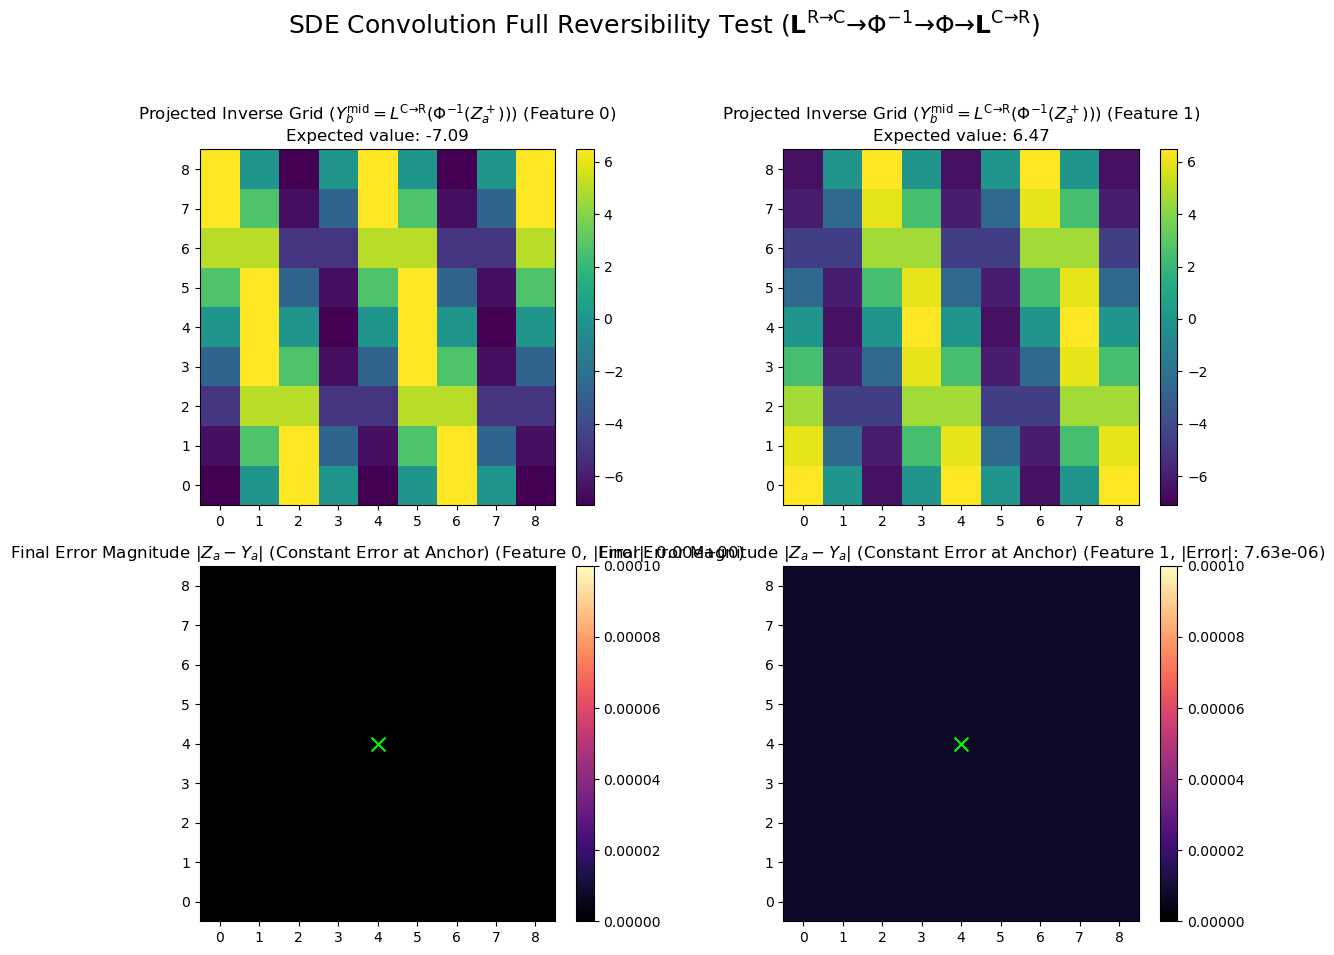


--- Testing FullSDEConv2d Layer with RANDOM Input (K=3, S=1) ---
Input Shape: torch.Size([2, 4, 16, 16])
Output Shape: torch.Size([2, 4, 16, 16])
Input HxW: 16x16, Output HxW: 16x16 (Expected: 16x16, Stride: 1, Padding: 1)
FullSDEConv2d executed successfully.


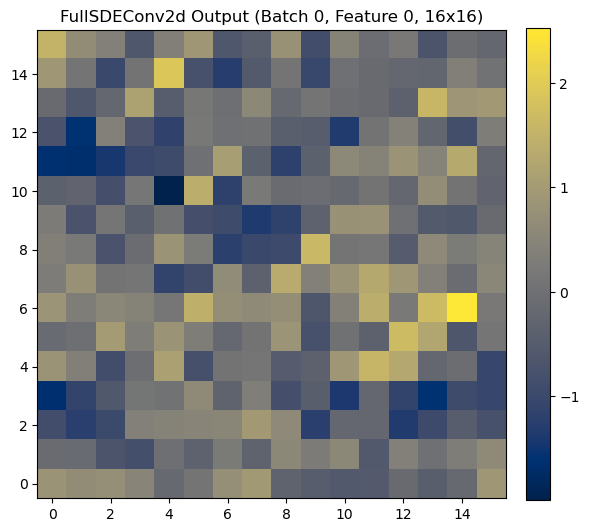


--- Testing FullSDEConv2d Layer with STRUCTURED Input (K=3, S=1) ---
Input Shape: torch.Size([1, 4, 16, 16])
Output Shape: torch.Size([1, 4, 16, 16])


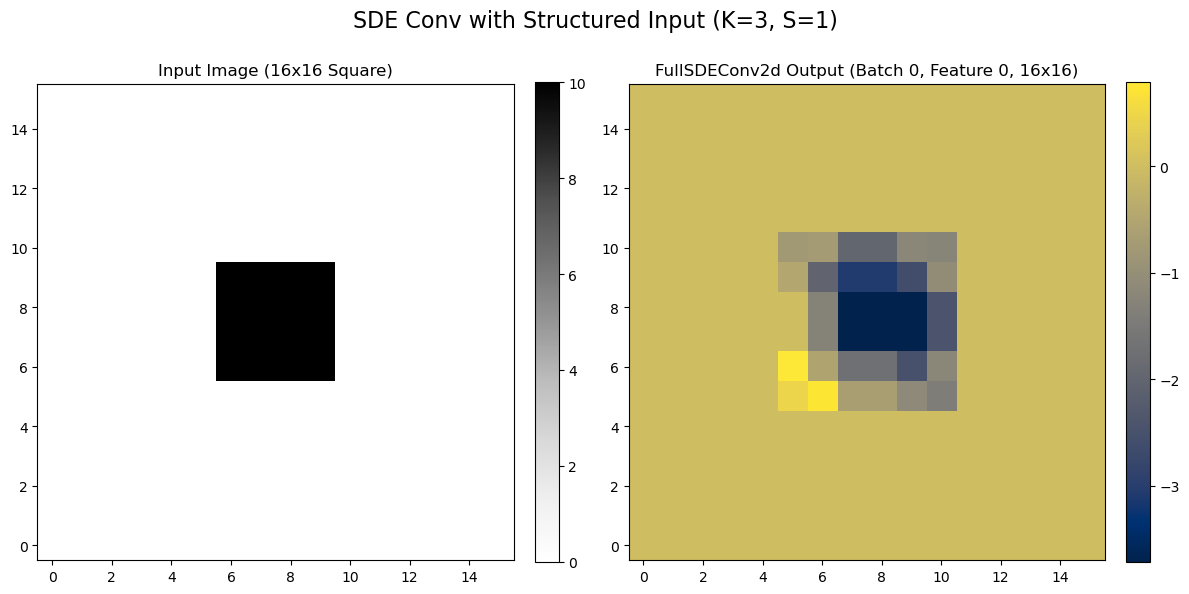


--- Testing FullSDEConv2d Layer with RANDOM Input (K=3, S=2) ---
Input Shape: torch.Size([2, 4, 16, 16])
Output Shape: torch.Size([2, 4, 8, 8])
Input HxW: 16x16, Output HxW: 8x8 (Expected: 8x8, Stride: 2, Padding: 1)
FullSDEConv2d executed successfully.


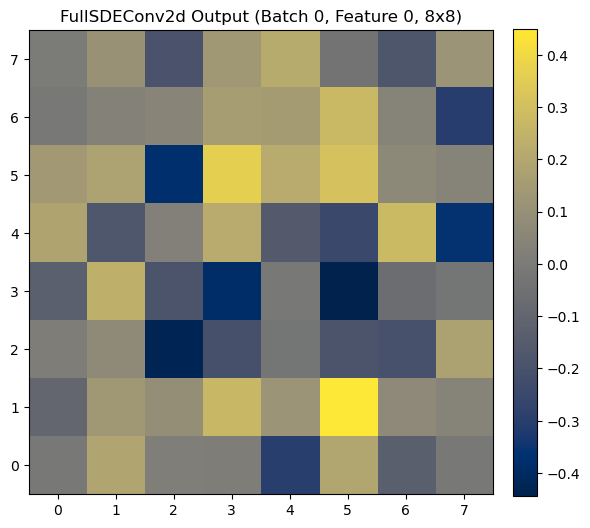


--- Comparing SDE Conv (Kalman Smoother) vs. Standard Conv (Denoising SDE Signal) (K=3) ---


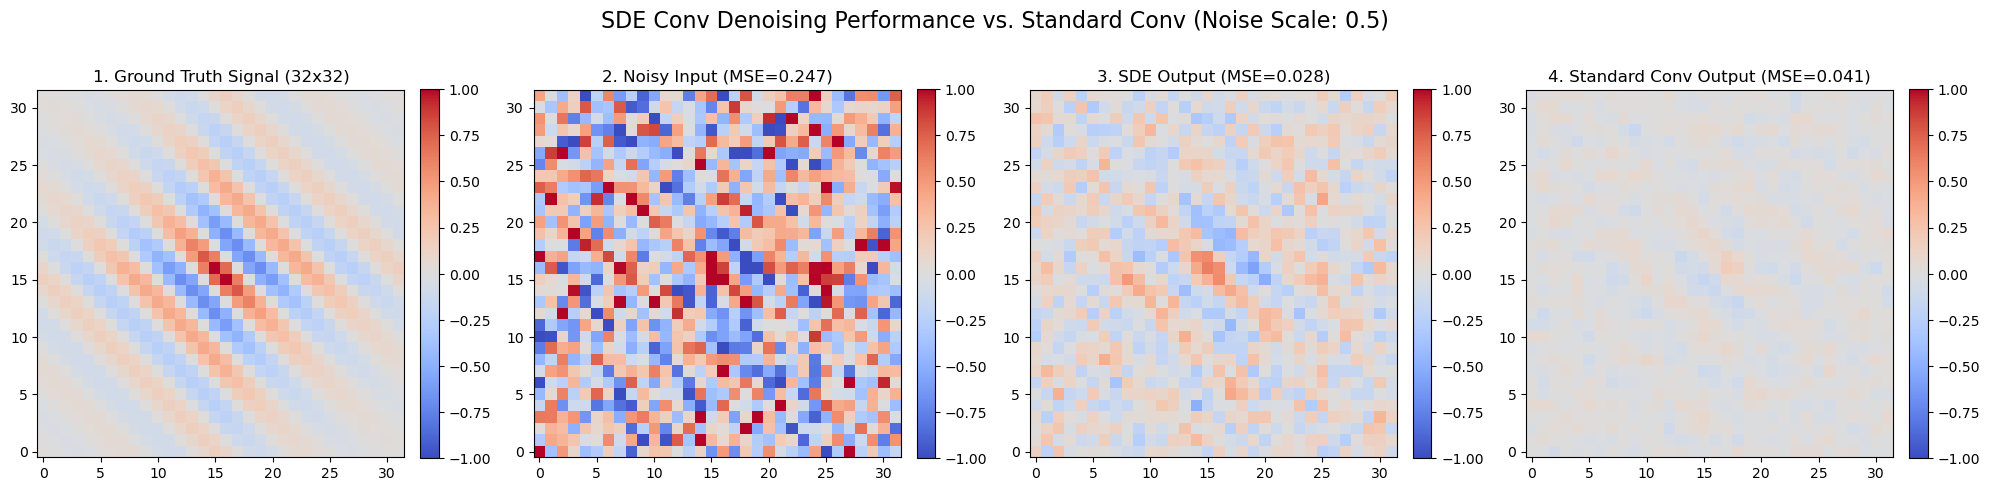


Denoising Test Results:
Initial Noise MSE (Input vs GT): 0.2472
SDE Conv Denoised MSE (Output vs GT): 0.0283
Standard Conv Denoised MSE (Output vs GT): 0.0408
SDE Conv Reduction Factor: 8.72x better than noisy input


In [3]:
# --- 1. Utility Functions ---

def complex_to_phase_intensity_image(z_r: torch.Tensor, z_i: torch.Tensor) -> np.ndarray:
    """
    Maps a complex tensor (R, I) of shape (N, N) to a single intensity image (N, N)
    based on the Phase (Hue). The phase is normalized to [0, 1] for visualization.
    """
    phase = torch.atan2(z_i, z_r)
    normalized_phase = (phase + math.pi) / (2 * math.pi)
    return normalized_phase.cpu().numpy()

def create_structured_input(H, W, D, square_size=4, value=10.0):
    """Creates a structured input tensor (white square on a black background)."""
    # Create a zero tensor (B=1, D, H, W)
    X = torch.zeros(1, D, H, W)
    
    # Calculate center and boundaries for the square
    h_start = (H - square_size) // 2
    h_end = h_start + square_size
    w_start = (W - square_size) // 2
    w_end = w_start + square_size
    
    # Set the square region to the specified value across all channels
    X[0, :, h_start:h_end, w_start:w_end] = value
    
    return X

def create_gabor_like_input(H, W, D, frequency=3.5, decay_factor=0.3):
    """Creates a directional (sine wave) input with a central Gaussian-like envelope."""
    # Create spatial coordinates
    y_coords, x_coords = torch.meshgrid(torch.arange(H), torch.arange(W), indexing='ij')
    y_norm = (y_coords.float() - H / 2) / (H / 2)
    x_norm = (x_coords.float() - W / 2) / (W / 2)

    # 1. Sine wave (oscillation along the y-axis, creating horizontal stripes)
    sin_wave = torch.sin(2 * math.pi * frequency * y_norm)

    # 2. Gaussian Envelope (central localization)
    gaussian_envelope = torch.exp(-(x_norm**2 + y_norm**2) / (2 * decay_factor**2))
    
    # Combined pattern
    pattern = sin_wave * gaussian_envelope
    
    # Scale and replicate across channels (B=1, D, H, W)
    X = pattern.unsqueeze(0).unsqueeze(0).repeat(1, D, 1, 1)
    
    # Normalize to [-1, 1] for stable feature input
    X = (X - X.min()) / (X.max() - X.min())
    X = X * 2 - 1 
    
    return X

def create_sde_generated_input(H, W, D, alpha_sq, omega_y, noise_scale=0.5):
    """
    Generates a ground-truth feature map based on SDE propagation from the center
    and adds measurement noise.
    
    Returns: X_noisy (B, D, H, W), X_gt (B, D, H, W)
    """
    
    # --- 1. Define SDE Dynamics (Simplified, Isotropic) ---
    # We assume symmetric dynamics and use the parameters for the vertical axis (y) 
    # to create the structure for both axes, for demonstration simplicity.
    
    # alpha_sq is assumed to be a scalar/vector for the feature dimension D
    alpha_sq = alpha_sq.view(1, D) # (1, D)
    omega_y = omega_y.view(1, D)   # (1, D)

    # --- 2. Generate Coordinates ---
    y_coords, x_coords = torch.meshgrid(torch.arange(H), torch.arange(W), indexing='ij')
    x_coords = x_coords.float()
    y_coords = y_coords.float()
    
    center_x = (W - 1) / 2.0
    center_y = (H - 1) / 2.0
    
    # Displacement from anchor (center) to pixel (i,j): Delta P' = P_ij - P_anchor
    # We use Delta P' = P_ij - P_center, so propagation is from the center (P_anchor)
    # to the current pixel (P_b)
    Delta_X_prime = x_coords - center_x # (H, W)
    Delta_Y_prime = y_coords - center_y # (H, W)

    # Delta P: (H, W, 2)
    Delta_P_prime = torch.stack([Delta_X_prime, Delta_Y_prime], dim=-1)

    # --- 3. Compute Propagation Kernel (Phi) from Center to all Pixels ---
    # Note: For generation, we assume a single direction (e.g., L->R and B->T for positive deltas)
    # Since alpha/omega are symmetric here, we don't need quadrant logic for generation.
    
    # Decay Term: exp(-alpha^2 |Delta p'|)
    decay_x = torch.exp(-alpha_sq * torch.abs(Delta_P_prime[..., 0].unsqueeze(-1)))
    decay_y = torch.exp(-alpha_sq * torch.abs(Delta_P_prime[..., 1].unsqueeze(-1)))
    decay_total = decay_x * decay_y # (H, W, D)

    # Phase Term: exp(-i * omega * Delta p')
    theta_xy = (omega_y * Delta_P_prime[..., 0].unsqueeze(-1)) + \
               (omega_y * Delta_P_prime[..., 1].unsqueeze(-1)) # (H, W, D)

    Phi_r = decay_total * torch.cos(theta_xy)      
    Phi_i = decay_total * -torch.sin(theta_xy) 

    # --- 4. Propagate Seed to Create Ground Truth Signal ---
    
    # Initialize a complex seed signal at the center (Na=1)
    Z_seed_r = torch.ones(1, D) * 5.0 # Constant initial state
    Z_seed_i = torch.zeros(1, D) 

    # Z_gt (Complex): (H, W, D)
    Z_gt_r = Phi_r * Z_seed_r # (H, W, D) * (1, D)
    Z_gt_i = Phi_i * Z_seed_i # This term is zero because Z_seed_i is zero
    
    # X_gt (Real): Use the real part as the observed/true real features
    X_gt = Z_gt_r.unsqueeze(0).permute(0, 3, 1, 2) # (1, D, H, W)

    # NEW FIX: Normalize X_gt to max magnitude 1.0 for stable MSE
    X_gt = X_gt / X_gt.abs().max() 
    
    # --- 5. Add Measurement Noise ---
    noise = torch.randn_like(X_gt) * noise_scale
    X_noisy = X_gt + noise
    
    return X_noisy, X_gt, alpha_sq, omega_y


# --- 2. SDE Convolution Helper Classes ---

class RealToComplexLinear(nn.Module):
    """
    Simulates the L^{R->C} layer: X -> Z^+ = X W_r + i X W_i.
    The weights W_r and W_i form a complex matrix A = W_r + i W_i.
    """
    def __init__(self, d_model: int):
        super().__init__()
        self.d_model = d_model
        # Weights for the real and imaginary parts of the complex projection
        self.W_r = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))
        self.W_i = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Input X: (..., D). Output Z_plus: (2, ..., D)"""
        Z_r = X @ self.W_r
        Z_i = X @ self.W_i
        # Stack output: (2, ..., D)
        return torch.stack([Z_r, Z_i], dim=0)

class ComplexToRealLinear(nn.Module):
    """
    Simulates the L^{C->R} layer: Y = Re(Z^+ A^{-1*}), where Z^+ = Z_r + i Z_i
    If A_inv = W_r_inv + i W_i_inv, then Y = Z_r W_r_inv^T - Z_i W_i_inv^T.
    The weights W_r and W_i here should be the real and imaginary parts of A^{-1}.
    """
    def __init__(self, d_model: int):
        super().__init__()
        self.d_model = d_model
        # These weights should be derived from the inverse of the R2C layer's complex weight.
        self.W_r = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))
        self.W_i = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))

    def forward(self, Z_plus: torch.Tensor) -> torch.Tensor:
        """Input Z_plus: (2, ..., D). Output Y: (..., D)"""
        Z_r, Z_i = torch.unbind(Z_plus, dim=0) # (..., D)
        
        # Y = Z_r @ W_r^T - Z_i @ W_i^T (The projection formula)
        Y = (Z_r @ self.W_r.T) - (Z_i @ self.W_i.T)
        return Y

class SpatialCoordinateTransformer(nn.Module):
    """
    Generates relative positions Delta p' for all pairs of anchor (Na) and source (Nb) pixels.
    Returns: torch.Tensor: Relative positions (Na, Nb, 2), where Na=K*K, Nb=K_source*K_source.
    """
    def __init__(self):
        super().__init__()
        pass

    def forward(self, K: int, K_source: int) -> torch.Tensor:
        """
        Generates untransformed relative positions $\Delta \mathbf{p} = \mathbf{p}_a - \mathbf{p}_b$.
        """
        y_coords, x_coords = torch.meshgrid(torch.arange(K_source), torch.arange(K_source), indexing='ij')
        p_b = torch.stack([x_coords.float(), y_coords.float()], dim=-1) # (K_source, K_source, 2)
        y_coords, x_coords = torch.meshgrid(torch.arange(K), torch.arange(K), indexing='ij')
        p_a = torch.stack([x_coords.float(), y_coords.float()], dim=-1) # (K, K, 2)

        p_b_flat = p_b.reshape(-1, 2) # (Nb, 2)
        p_a_flat = p_a.reshape(-1, 2) # (Na, 2)

        Delta_P = p_a_flat.unsqueeze(1) - p_b_flat.unsqueeze(0)
        
        return Delta_P # (K*K, K*K, 2)


# --- 3. SDE Convolution Kernel Class (Core Logic - Precision Weighted for Convolution) ---

class SDEConvolution(nn.Module):
    """
    Implements a single SDE-based convolutional kernel operation.
    It uses precision-weighted averaging for the main convolution path.
    """
    def __init__(self, d_model: int, kernel_size: int, sigma_x=1.0, sigma_y=1.0, eta=1e-3, gamma=1e-3):
        super().__init__()
        if kernel_size % 2 == 0:
            raise ValueError("Kernel size must be odd for a central anchor.")
            
        self.d_model = d_model
        self.kernel_size = kernel_size
        self.num_pixels = kernel_size * kernel_size
        self.anchor_idx = self.num_pixels // 2 
        
        # --- Precision weighting constants (Added) ---
        self.sigma_x = sigma_x
        self.sigma_y = sigma_y
        self.eta = eta
        self.gamma = gamma
        
        # 1. Real-to-Complex and Complex-to-Real Layers
        self.real_to_complex = RealToComplexLinear(d_model)
        self.complex_to_real = ComplexToRealLinear(d_model)
        
        # 2. Spatial Coordinate Transformer (returns Na x Nb x 2)
        self.coord_transformer = SpatialCoordinateTransformer()
        
        # 3. SDE Transition Parameters 
        self.raw_alpha_l = nn.Parameter(torch.zeros(d_model))
        self.raw_alpha_r = nn.Parameter(torch.zeros(d_model))
        self.raw_alpha_b = nn.Parameter(torch.zeros(d_model))
        self.raw_alpha_t = nn.Parameter(torch.zeros(d_model))

        self.omega_l = nn.Parameter(torch.zeros(d_model))
        self.omega_r = nn.Parameter(torch.zeros(d_model))
        self.omega_b = nn.Parameter(torch.zeros(d_model))
        self.omega_t = nn.Parameter(torch.zeros(d_model))
        
        self._init_sde_parameters()

    @staticmethod
    def _core_transition_fn(
        delta_p_prime: torch.Tensor,
        z_sb: torch.Tensor,
        alpha_x_sq_NND: torch.Tensor,
        alpha_y_sq_NND: torch.Tensor,
        omega_x_NND: torch.Tensor,
        omega_y_NND: torch.Tensor,
    ) -> torch.Tensor:
        """
        Computes the state transition $\mathbf{\hat{z}}_{\mathbf{s}, ab} = \boldsymbol{\Phi}_{xy} \odot \mathbf{z}_{\mathbf{s}, b}$.
        
        Note: z_sb may have batched/flattened features in the last dimension (M*D).
        Phi must be stretched to match.
        """
        delta_x_prime = delta_p_prime[..., 0]  # (Na, Nb)
        delta_y_prime = delta_p_prime[..., 1]  # (Na, Nb)
        
        z_sb_r, z_sb_i = torch.unbind(z_sb, dim=0) # (Nb, D_effective)

        # 2. Compute Decay Term: always exp(-alpha^2 |Delta p'|)
        decay_x = torch.exp(-alpha_x_sq_NND * torch.abs(delta_x_prime.unsqueeze(-1))) 
        decay_y = torch.exp(-alpha_y_sq_NND * torch.abs(delta_y_prime.unsqueeze(-1)))
        decay_total = decay_x * decay_y # (Na, Nb, D)
        
        # 3. Compute Phase Term
        dx_r = delta_x_prime.unsqueeze(-1) # (Na, Nb, 1)
        dy_r = delta_y_prime.unsqueeze(-1) # (Na, Nb, 1)
        theta_xy = (omega_x_NND * dx_r) + (omega_y_NND * dy_r)

        # We define Phi as: Phi = Decay * (cos(theta) - i*sin(theta))
        Phi_r = decay_total * torch.cos(theta_xy)      # (Na, Nb, D)
        Phi_i = decay_total * -torch.sin(theta_xy)     # (Na, Nb, D) 
        
        # --- FIX: Stretch Phi over the batch dimension M if z_sb is flattened ---
        D_model = Phi_r.shape[-1]
        D_effective = z_sb_r.shape[-1]
        M = D_effective // D_model

        if M > 1:
            # Expand Phi over the M dimension to match z_sb shape (N_b, M*D_model)
            # 1. Expand Phi_r/i: (Na, Nb, D) -> (Na, Nb, M, D)
            Phi_r_expanded = Phi_r.unsqueeze(2).repeat(1, 1, M, 1)
            Phi_i_expanded = Phi_i.unsqueeze(2).repeat(1, 1, M, 1)
            
            # 2. Flatten the last two dimensions: (Na, Nb, M*D)
            Phi_r_final = Phi_r_expanded.reshape(Phi_r.shape[0], Phi_r.shape[1], -1) 
            Phi_i_final = Phi_i_expanded.reshape(Phi_i.shape[0], Phi_i.shape[1], -1) 
        else:
            Phi_r_final = Phi_r
            Phi_i_final = Phi_i
        
        # 5. Apply the Transition (Complex Dot Product)
        # z_sb_r_broadcast is (1, Nb, D_effective)
        z_sb_r_broadcast = z_sb_r.unsqueeze(0) 
        z_sb_i_broadcast = z_sb_i.unsqueeze(0) 
        
        # Phi_final is (Na, Nb, D_effective)
        z_hat_r = (Phi_r_final * z_sb_r_broadcast) - (Phi_i_final * z_sb_i_broadcast)  
        z_hat_i = (Phi_r_final * z_sb_i_broadcast) + (Phi_i_final * z_sb_r_broadcast)  
        
        return torch.stack([z_hat_r, z_hat_i], dim=0) # (2, Na, Nb, D_effective)

    @staticmethod
    def _quadrant_transition_fn(
        delta_p_prime: torch.Tensor,
        z_sb: torch.Tensor,
        alpha_sq_params: dict,
        omega_params: dict,
    ) -> torch.Tensor:
        """
        Applies the SDE state transition, handling quadrant selection.
        Input: delta_p_prime (Na, Nb, 2), z_sb (2, Nb, D_effective). Output: (2, Na, Nb, D_effective)
        """
        Na, Nb, _ = delta_p_prime.shape 
        D = omega_params['l'].shape[0]

        delta_x_prime = delta_p_prime[..., 0] # (Na, Nb)
        delta_y_prime = delta_p_prime[..., 1] # (Na, Nb)

        # --- 1. Compute Indicator Masks ---
        mask_x_l = (delta_x_prime > 0).float() 
        mask_x_r = (delta_x_prime < 0).float() 
        mask_y_b = (delta_y_prime > 0).float() 
        mask_y_t = (delta_y_prime < 0).float() 
        
        mask_x_l_r = mask_x_l.unsqueeze(-1) # (Na, Nb, 1)
        mask_x_r_r = mask_x_r.unsqueeze(-1)
        mask_y_b_r = mask_y_b.unsqueeze(-1)
        mask_y_t_r = mask_y_t.unsqueeze(-1)

        def get_broadcast_param(param_dict, key):
            # (1, 1, D)
            return param_dict[key].view(1, 1, D)

        # --- 2. Compute Spatially-Varying Alpha^2 (Na, Nb, D) ---
        alpha_x_sq_NND = (mask_x_l_r * get_broadcast_param(alpha_sq_params, 'l')) + \
                             (mask_x_r_r * get_broadcast_param(alpha_sq_params, 'r'))
        
        alpha_y_sq_NND = (mask_y_b_r * get_broadcast_param(alpha_sq_params, 'b')) + \
                             (mask_y_t_r * get_broadcast_param(alpha_sq_params, 't'))
        
        # --- 3. Compute Spatially-Varying Omega (Na, Nb, D) ---
        omega_x_NND = (mask_x_l_r * get_broadcast_param(omega_params, 'l')) + \
                      (mask_x_r_r * get_broadcast_param(omega_params, 'r'))
        
        omega_y_NND = (mask_y_b_r * get_broadcast_param(omega_params, 'b')) + \
                      (mask_y_t_r * get_broadcast_param(omega_params, 't'))

        # --- 4. Call Core Transition Logic ---
        return SDEConvolution._core_transition_fn(
            delta_p_prime,  
            z_sb,           
            alpha_x_sq_NND, 
            alpha_y_sq_NND, 
            omega_x_NND,    
            omega_y_NND,
        )

    def _init_sde_parameters(self):
        # Initialize parameters
        fan_in = self.d_model
        bound = 1.0 / math.sqrt(fan_in)
        for p in [self.raw_alpha_l, self.raw_alpha_r, self.raw_alpha_b, self.raw_alpha_t,
                  self.omega_l, self.omega_r, self.omega_b, self.omega_t]:
            nn.init.uniform_(p, -bound, bound)

    def _get_sde_params(self):
        """Constructs the parameter dicts, applying softplus to raw alphas."""
        
        # Apply softplus to ensure alpha^2 is non-negative
        alpha_l_sq = F.softplus(self.raw_alpha_l)
        alpha_r_sq = F.softplus(self.raw_alpha_r)
        alpha_b_sq = F.softplus(self.raw_alpha_b)
        alpha_t_sq = F.softplus(self.raw_alpha_t)

        alpha_sq_params = {
            'l': alpha_l_sq, 'r': alpha_r_sq, 
            'b': alpha_b_sq, 't': alpha_t_sq
        }
        
        omega_params = {
            'l': self.omega_l, 'r': self.omega_r, 
            'b': self.omega_b, 't': self.omega_t
        }
        return alpha_sq_params, omega_params

    # --- Precision Calculation (Restored) ---
    def _compute_precisions(self, delta_p_prime, alpha_sq_params):
        """
        Computes precision weights 1/σ_V^2 for each offset (u,v).
        Input: delta_p_prime (N_pixels, 2)
        Output: precisions (N_pixels, 1)
        """
        dx = torch.abs(delta_p_prime[..., 0]) # (N_pixels,)
        dy = torch.abs(delta_p_prime[..., 1]) # (N_pixels,)

        # Use mean alpha^2 across all feature dimensions (D) for the scalar variance calculation
        alpha_x_sq = 0.5 * (alpha_sq_params['l'].mean() + alpha_sq_params['r'].mean())
        alpha_y_sq = 0.5 * (alpha_sq_params['b'].mean() + alpha_sq_params['t'].mean())

        denom_x = -2 * alpha_x_sq 
        denom_y = -2 * alpha_y_sq 
        
        # --- Handle the limit where alpha -> 0 using Taylor expansion for stability ---
        ALPHA_EPSILON = 1e-6
        
        is_denom_x_near_zero = torch.abs(denom_x) < ALPHA_EPSILON
        sigma_x_sq_term = torch.where(
            is_denom_x_near_zero,
            self.sigma_x**2 * dx, 
            self.sigma_x**2 * (torch.exp(denom_x * dx) - 1) / denom_x
        )

        is_denom_y_near_zero = torch.abs(denom_y) < ALPHA_EPSILON
        sigma_y_sq_term = torch.where(
            is_denom_y_near_zero,
            self.sigma_y**2 * dy,
            self.sigma_y**2 * (torch.exp(denom_y * dy) - 1) / denom_y
        )
        
        cross_term = self.eta**2 * torch.exp(denom_x * dx + denom_y * dy) + self.gamma**2
        sigma_V_sq = sigma_x_sq_term * sigma_y_sq_term + cross_term
        
        precisions = 1.0 / (sigma_V_sq.unsqueeze(-1) + 1e-8)
        return precisions  # (N_pixels, 1)


    # --- Method for Batch Processing (PRECISION WEIGHTED) ---
    def forward_batch_patches(self, X_batch_patches: torch.Tensor) -> torch.Tensor:
        """
        Calculates the final precision-weighted average, real-valued feature for a batch of patches.
        
        Input X_batch_patches: (N_patch, N_pixels, D). 
        Output Y_anchors: (N_patch, D)
        """
        N_patch, N_pixels, D = X_batch_patches.shape
        K = self.kernel_size

        # 1. Real -> Complex Layer
        X_flat_reshaped = X_batch_patches.reshape(N_patch * N_pixels, D)
        Z_plus_flat = self.real_to_complex(X_flat_reshaped) # (2, N_patch * N_pixels, D)
        Z_plus_batch = Z_plus_flat.view(2, N_patch, N_pixels, D)
        
        # 2. Spatial Coordinate Transform ($\Delta p'$): (N*N, N*N, 2)
        Delta_P_prime_all = self.coord_transformer(K, K)
        # Select displacement relative to center anchor (Na=1)
        # Delta_P_prime_anchor_N_pixels: (N_pixels, 2)
        Delta_P_prime_anchor_N_pixels = Delta_P_prime_all[self.anchor_idx, :] 
        
        alpha_sq_params, omega_params = self._get_sde_params()
        
        # 3. Compute Precision Weights (N_pixels, 1)
        precisions = self._compute_precisions(Delta_P_prime_anchor_N_pixels, alpha_sq_params) 
        precisions_sum = precisions.sum(dim=0).unsqueeze(0) # (1, 1)
        
        # Reshape Z_plus_batch for quadrant_transition_fn: (2, N_pixels, N_patch, D)
        Z_patch_pixels = Z_plus_batch.permute(0, 2, 1, 3) 

        # 4. SDE Transition (Propagation to Anchor): (2, Na=1, Nb=N_pixels, D)
        # The transition function expects (Na, Nb, 2), but we only need N_pixels sources
        Delta_P_prime_single_anchor = Delta_P_prime_anchor_N_pixels.unsqueeze(0) # (1, N_pixels, 2)
        
        # FIX: Added .contiguous() before .view() to resolve the RuntimeError
        # z_sb has shape (2, N_pixels, N_patch * D)
        Z_hat_full = SDEConvolution._quadrant_transition_fn(
            delta_p_prime=Delta_P_prime_single_anchor, 
            z_sb=Z_patch_pixels.contiguous().view(2, N_pixels, N_patch * D), # Collapse N_patch and D for batching
            alpha_sq_params=alpha_sq_params,
            omega_params=omega_params,
        ) # Output: (2, Na=1, Nb=N_pixels, N_patch * D)
        
        # Reshape back: (2, N_patch, N_pixels, D)
        # FIX: Applied .contiguous() before .view() here as well for safety
        Z_hat_full = Z_hat_full.contiguous().view(2, 1, N_pixels, N_patch, D).squeeze(1).permute(0, 2, 1, 3) 

        # 5. Precision-weighted average
        # precisions_broadcast: (1, 1, N_pixels, 1)
        precisions_broadcast = precisions.unsqueeze(0).unsqueeze(0) 

        # Weighted complex sum: (2, N_patch, N_pixels, D) -> sum over N_pixels -> (2, N_patch, 1, D)
        Z_hat_weighted_sum = (precisions_broadcast * Z_hat_full).sum(dim=2, keepdim=True)

        # Weighted Average: (2, N_patch, 1, D)
        # precisions_sum is (1, 1). Need to stretch to (1, 1, 1, 1) for broadcasting
        Z_hat_weighted = Z_hat_weighted_sum / precisions_sum.unsqueeze(0).unsqueeze(0).unsqueeze(0)
        
        # 6. Complex to Real Transformation
        Y_anchors = self.complex_to_real(Z_hat_weighted.view(2, N_patch, D))
        
        return Y_anchors # (N_patch, D)

    # --- Previous Reversibility Test Method (UNWEIGHTED) ---
    def forward_test_anchor(self, X_patch: torch.Tensor) -> torch.Tensor:
        """
        Calculates the final unweighted summed, real-valued feature ONLY for the central anchor pixel.
        """
        D = self.d_model
        
        # X_patch: (N_pixels, D)
        X_flat = X_patch.reshape(self.num_pixels, D)
        
        # Call the batch processing method with N_patch=1
        X_batch_patches = X_flat.unsqueeze(0) # (1, N_pixels, D)
        
        Y_anchors = self.forward_batch_patches(X_batch_patches) # (1, D)
        
        return Y_anchors.squeeze(0) # (D)


# --- 4. Full Convolution Wrapper Class (The Drop-in Replacement) ---

class FullSDEConv2d(nn.Module):
    """
    SDE Convolution wrapper that implements the full 2D sliding-window operation,
    making it a drop-in replacement for nn.Conv2d.
    """
    def __init__(self, d_model: int, kernel_size: int, stride: int = 1, padding: int = None,
                 sigma_x=1.0, sigma_y=1.0, eta=1e-3, gamma=1e-3):
        super().__init__()
        self.d_model = d_model
        self.kernel_size = kernel_size
        self.stride = stride 
        
        if padding is None:
            self.padding = kernel_size // 2
        else:
            self.padding = padding
            
        # The core SDE kernel logic (now precision-weighted)
        self.sde_kernel = SDEConvolution(d_model, kernel_size, sigma_x, sigma_y, eta, gamma)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Input X: (B, D, H, W). Output Y: (B, D, H', W')
        """
        B, D, H, W = X.shape
        K = self.kernel_size
        S = self.stride 
        
        # 1. Extract Patches using nn.Unfold
        patches_unfolded = F.unfold(X, kernel_size=K, padding=self.padding, stride=S)
        
        N_patches = patches_unfolded.shape[2] # H_out * W_out
        
        # 2. Reshape for SDE Kernel
        N_pixels = K * K
        patches_reordered = patches_unfolded.transpose(1, 2).reshape(B * N_patches, N_pixels, D)
        
        # 3. Apply SDE Kernel Batch Processing (Precision Weighted)
        Y_flat_anchors = self.sde_kernel.forward_batch_patches(patches_reordered)  # (B * N_patches, D)
        
        # 4. Reshape and Reassemble
        Y_anchors_reordered = Y_flat_anchors.view(B, N_patches, D).transpose(1, 2)
        
        # Calculate output dimensions using the stride
        H_out = math.floor((H + 2 * self.padding - K) / S) + 1
        W_out = math.floor((W + 2 * self.padding - K) / S) + 1

        # Final output shape: (B, D, H_out, W_out)
        Y = Y_anchors_reordered.view(B, D, H_out, W_out)

        return Y

# --- 5. Forward/Inverse Kernel Abstractions for Test (UNWEIGHTED SUMMATION) ---
# NOTE: These functions implement the pure Phi^-1 -> Phi identity test and must use 
# an unweighted sum, as requested.

def sde_conv_kernel_inverse_spread(sde_conv: SDEConvolution, p_grid_flat: torch.Tensor, Z_a_plus: torch.Tensor) -> torch.Tensor:
    """
    Inverse Kernel: Propagates a single anchor feature (Z_a_plus) back to all source positions (p_grid_flat).
    """
    K = sde_conv.kernel_size
    N = sde_conv.num_pixels
    
    Delta_P_prime_all = sde_conv.coord_transformer(K, K) # (N*N, N*N, 2)
    p_anchor_relative = Delta_P_prime_all[sde_conv.anchor_idx, sde_conv.anchor_idx].view(1, 2) # (1, 2)
    
    # Inverse displacement: p_b - p_a (Na=N*N, Nb=1, 2)
    Delta_P_inverse_displacement = p_grid_flat.unsqueeze(1) - p_anchor_relative.unsqueeze(0) 

    alpha_sq_params, omega_params = sde_conv._get_sde_params()

    # Z_a_plus is already (2, 1, D). Pass it directly as z_sb=(2, Nb=1, D).
    Z_mid_full = SDEConvolution._quadrant_transition_fn(
        delta_p_prime=Delta_P_inverse_displacement, 
        z_sb=Z_a_plus, # (2, 1, D)
        alpha_sq_params=alpha_sq_params,
        omega_params=omega_params,
    ) # (2, N*N, 1, D)

    return Z_mid_full.squeeze(2) # (2, N*N, D)


def sde_conv_kernel_forward_sum(sde_conv: SDEConvolution, p_grid_flat: torch.Tensor, Z_mid: torch.Tensor) -> torch.Tensor:
    """
    Forward Kernel: Propagates all source features (Z_mid) to the anchor (p_a) and performs an unweighted sum.
    """
    K = sde_conv.kernel_size
    N = sde_conv.num_pixels
    
    Delta_P_prime_all = sde_conv.coord_transformer(K, K) # (N*N, N*N, 2)
    p_anchor_relative = Delta_P_prime_all[sde_conv.anchor_idx, sde_conv.anchor_idx].view(1, 2) # (1, 2)
    
    # Forward displacement: p_a - p_b (Na=1, Nb=N*N, 2)
    Delta_P_forward_displacement = p_anchor_relative.unsqueeze(1) - p_grid_flat.unsqueeze(0) 

    alpha_sq_params, omega_params = sde_conv._get_sde_params()

    Z_hat_full = SDEConvolution._quadrant_transition_fn(
        delta_p_prime=Delta_P_forward_displacement,      
        z_sb=Z_mid,                  
        alpha_sq_params=alpha_sq_params,
        omega_params=omega_params,
    ) # (2, 1, N*N, D)
    
    # UNWEIGHTED SUM (as required for the reversibility identity)
    Z_a_summed = Z_hat_full.sum(dim=2) # (2, 1, D)
    return Z_a_summed


# --- 6. Main Test Functions (Restored Unweighted Reversibility Test) ---

def visualize_full_pipeline_reversibility_with_class(N=9, D=2, anchor_pos=None):
    """
    Performs the full SDE Convolution reversibility test (L^R->C -> Phi^-1 -> Phi -> L^C->R)
    using the SDEConvolution class and kernel abstractions. (Unweighted Summation Test)
    """
    
    # --- Setup ---
    K = N
    D = D
    if anchor_pos is None:
        anchor_pos = (N // 2, N // 2)
    
    print(f"\n--- SDEConvolution Full Reversibility Verification (Unweighted Sum) ({N}x{N} Grid, D={D}) ---")
    
    # Instantiate the SDE Convolution layer 
    # Use standard noise settings, as they are ignored by the Phi^-1 -> Phi test logic
    sde_conv = FullSDEConv2d(d_model=D, kernel_size=K).sde_kernel 
    
    # 1. Force R2C and C2R to be perfect complex inverses for L^R->C o L^C->R = Identity
    
    A_R = torch.randn(D, D) / math.sqrt(D)
    A_I = torch.randn(D, D) / math.sqrt(D)
    A = torch.complex(A_R, A_I)
    
    A_inv = torch.linalg.inv(A)
    A_inv_R = A_inv.real
    A_inv_I = A_inv.imag

    sde_conv.real_to_complex.W_r.data = A_R.T 
    sde_conv.real_to_complex.W_i.data = A_I.T

    sde_conv.complex_to_real.W_r.data = A_inv_R
    sde_conv.complex_to_real.W_i.data = A_inv_I

    # 2. Force alpha^2 to zero for perfect SDE reversibility (no decay)
    zero_alpha = torch.full((D,), -100.0) 
    sde_conv.raw_alpha_l.data = zero_alpha
    sde_conv.raw_alpha_r.data = zero_alpha
    sde_conv.raw_alpha_b.data = zero_alpha
    sde_conv.raw_alpha_t.data = zero_alpha
    
    # 3. Use arbitrary non-zero omegas for spatial rotation visualization
    OMEGA_L = torch.tensor([math.pi / 2.0] * D) 
    OMEGA_R = torch.tensor([-math.pi / 4.0] * D)
    OMEGA_B = torch.tensor([math.pi / 8.0] * D)
    OMEGA_T = torch.tensor([-math.pi / 8.0] * D)
    sde_conv.omega_l.data = OMEGA_L
    sde_conv.omega_r.data = OMEGA_R
    sde_conv.omega_b.data = OMEGA_B
    sde_conv.omega_t.data = OMEGA_T
    
    # --- Coordinate and Input Setup ---
    y_coords, x_coords = torch.meshgrid(torch.arange(N), torch.arange(N), indexing='ij')
    p_grid = torch.stack([x_coords.float(), y_coords.float()], dim=-1) # (N, N, 2)
    p_grid_flat = p_grid.view(N * N, 2) # (N*N, 2)
    
    # The initial real feature vector (Input: Z_a, Shape: (1, D))
    Z_a = torch.randn(1, D) * 10 + 5 

    # --- Step 0: Real Input -> Complex State ($Z_a \to Z_a^+$) ---
    Z_a_plus = sde_conv.real_to_complex(Z_a) # (2, 1, D)
    
    
    # --- Step 1: Inverse Propagation ($Z_a^+ \to Z_b^{mid}$) using Kernel Abstraction ---
    # Spread the anchor feature Z_a_plus back over the entire grid
    Z_mid = sde_conv_kernel_inverse_spread(
        sde_conv,       
        p_grid_flat,    
        Z_a_plus,       
    ) # (2, N*N, D)

    # --- Visualization Checkpoint 1: The Projected Inverse Grid ($Y_b^{mid}$) ---
    Y_mid_flat = sde_conv.complex_to_real(Z_mid) # (N*N, D)
    
    # --- Step 2: Forward Propagation ($Z_b^{mid} \to Z_a^{final+}$) using Kernel Abstraction ---
    # Sum the contributions of the intermediate state Z_mid (all points) back to the anchor
    Z_a_final_plus_summed = sde_conv_kernel_forward_sum(
        sde_conv,         
        p_grid_flat,      
        Z_mid,            
    ) # (2, 1, D)
    
    
    # --- Step 3: Complex -> Real Output ($Z_a^{final+} \to Y_a$) ---
    Y_a = sde_conv.complex_to_real(Z_a_final_plus_summed).squeeze(0) # (D)


    # --- Step 4: Verification and Visualization ---
    
    # Calculate Error
    error_vector = Z_a.squeeze(0) - Y_a
    max_error = torch.max(torch.abs(error_vector))
    
    print(f"\nInitial Real Input Z_a (first 3 dims): {Z_a.squeeze(0)[:3].tolist()}")
    print(f"Final Real Output Y_a (first 3 dims): {Y_a[:3].tolist()}")
    print(f"Max Absolute Error (|Z_a - Y_a|): {max_error.item():.6e}")
    
    if max_error.item() < 1e-5:
        print("Status: SUCCESS (Reversibility check passed with high precision, $L^{\\mathrm{R} \\to \\mathrm{C}} \\to \\mathbf{\\Phi}^{-1} \\to \\mathbf{\\Phi} \\to L^{\\mathrm{C} \\to \\mathrm{R}} \\approx \\mathbf{I}$)")
    else:
        print(f"Status: FAILURE (Error is higher than expected: {max_error.item():.2e})")

    # Reshape the projected inverse grid for visualization: (N, N, D)
    Y_mid_grid = Y_mid_flat.view(N, N, D)
    
    # Visualization Setup: 2 Rows (Projected Inverse Grid, Error), D Columns
    fig, axes = plt.subplots(2, D, figsize=(6 * D, 10))
    if D == 1: axes = axes.reshape(2, 1)

    # Titles using Mathtext compatible notation
    titles = [
        "Projected Inverse Grid ($Y_b^{\\mathrm{mid}} = L^{\\mathrm{C} \\to \\mathrm{R}}(\\Phi^{-1}(Z_a^+))$)",
        "Final Error Magnitude $|Z_a - Y_a|$ (Constant Error at Anchor)",
    ]
    
    for d in range(D):
        # --- Row 1: Projected Inverse Grid ($Y_b^{mid}$) ---
        img_mid = Y_mid_grid[:, :, d].detach().cpu().numpy()
        ax = axes[0, d]
        vmin = Z_a.min().item()
        vmax = Z_a.max().item()
        im_mid = ax.imshow(img_mid, cmap='viridis', origin='lower', vmin=vmin, vmax=vmax) 
        ax.set_title(f'{titles[0]} (Feature {d})\nExpected value: {Z_a[0, d].item():.2f}')
        
        plt.colorbar(im_mid, ax=ax, fraction=0.046, pad=0.04)

        # --- Row 2: Final Error Magnitude ---
        ax = axes[1, d]
        error_magnitude = torch.abs(error_vector[d]).item()
        error_map = torch.full((N, N), error_magnitude)
        vmax_err = max(1e-4, max_error.item() * 1.5) 
        im_err = ax.imshow(error_map.detach().cpu().numpy(), cmap='magma', origin='lower', vmin=0, vmax=vmax_err)
        ax.scatter(anchor_pos[1], anchor_pos[0], color='lime', marker='x', s=100)
        ax.set_title(f'{titles[1]} (Feature {d}, |Error|: {error_magnitude:.2e})')
        plt.colorbar(im_err, ax=ax, fraction=0.046, pad=0.04)
        
    for ax in axes.flat:
        ax.set_xticks(np.arange(N))
        ax.set_yticks(np.arange(N))
        
    # Using \Phi (Greek Phi) instead of \mathbf{\Phi} (bold Phi) for Mathtext compatibility
    fig.suptitle("SDE Convolution Full Reversibility Test ($\\mathbf{L}^{\\mathrm{R} \\to \\mathrm{C}} \\to \\Phi^{-1} \\to \\Phi \\to \\mathbf{L}^{\\mathrm{C} \\to \\mathrm{R}}$)", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def test_convolution_with_structured_input(H=16, W=16, D=4, K=3, S=1):
    """
    Tests FullSDEConv2d with a structured input (a centered square).
    This test replaces the random input X with a structured X.
    """
    
    print(f"\n--- Testing FullSDEConv2d Layer with STRUCTURED Input (K={K}, S={S}) ---")
    
    # Input tensor: (Batch=1, Channels/D_model, Height, Width)
    X = create_structured_input(H, W, D)
    
    # Instantiate the full layer, passing the stride
    sde_conv_layer = FullSDEConv2d(d_model=D, kernel_size=K, stride=S)
    
    # 1. Manually set parameters for stability/predictability in the demo
    # Force alpha^2 to zero (no decay) for initial stability
    zero_alpha = torch.full((D,), -100.0)
    sde_conv_layer.sde_kernel.raw_alpha_l.data = zero_alpha
    sde_conv_layer.sde_kernel.raw_alpha_r.data = zero_alpha
    sde_conv_layer.sde_kernel.raw_alpha_b.data = zero_alpha
    sde_conv_layer.sde_kernel.raw_alpha_t.data = zero_alpha
    
    # Set small, distinct omegas for a noticeable (but simple) spatial transformation
    sde_conv_layer.sde_kernel.omega_l.data = torch.linspace(0.1, 0.4, D)
    sde_conv_layer.sde_kernel.omega_r.data = torch.linspace(0.5, 0.8, D)


    # 2. Run the forward pass
    print(f"Input Shape: {X.shape}")
    Y = sde_conv_layer(X)
    
    # 3. Verification and Visualization
    H_out, W_out = Y.shape[2:]
    
    print(f"Output Shape: {Y.shape}")
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # --- Plot 1: Input Image ---
    # The input is the same across all channels, so we show channel 0
    img_in = X[0, 0, :, :].detach().cpu().numpy()
    im_in = axes[0].imshow(img_in, cmap='Greys', origin='lower')
    axes[0].set_title(f'Input Image (16x16 Square)')
    plt.colorbar(im_in, ax=axes[0], fraction=0.046, pad=0.04)

    # --- Plot 2: Output Feature Map ---
    # Visualize the first batch, first feature map
    img_out = Y[0, 0, :, :].detach().cpu().numpy()
    im_out = axes[1].imshow(img_out, cmap='cividis', origin='lower')
    
    axes[1].set_title(f'FullSDEConv2d Output (Batch 0, Feature 0, {H_out}x{W_out})')
    plt.colorbar(im_out, ax=axes[1], fraction=0.046, pad=0.04)

    fig.suptitle(f"SDE Conv with Structured Input (K={K}, S={S})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def test_full_convolution(H=16, W=16, D=4, K=3, S=1):
    """
    Demonstrates the usage of the FullSDEConv2d class on a simulated feature map
    using random input (the original test).
    Includes support for striding (S > 1).
    """
    
    print(f"\n--- Testing FullSDEConv2d Layer with RANDOM Input (K={K}, S={S}) ---")
    
    # Input tensor: (Batch, Channels/D_model, Height, Width)
    B = 2
    X = torch.randn(B, D, H, W)
    
    # Instantiate the full layer, passing the stride
    sde_conv_layer = FullSDEConv2d(d_model=D, kernel_size=K, stride=S)
    
    # 1. Manually set parameters for stability/predictability in the demo (optional)
    # Force alpha^2 to zero (no decay) for initial stability
    zero_alpha = torch.full((D,), -100.0)
    sde_conv_layer.sde_kernel.raw_alpha_l.data = zero_alpha
    
    # Set a small, distinct omega
    sde_conv_layer.sde_kernel.omega_l.data = torch.linspace(0.1, 0.4, D)

    # 2. Run the forward pass
    print(f"Input Shape: {X.shape}")
    Y = sde_conv_layer(X)
    
    # 3. Verification
    H_out, W_out = Y.shape[2:]
    
    # Calculate expected output size for verification
    padding = sde_conv_layer.padding
    H_expected = math.floor((H + 2 * padding - K) / S) + 1
    W_expected = math.floor((W + 2 * padding - K) / S) + 1
    
    print(f"Output Shape: {Y.shape}")
    print(f"Input HxW: {H}x{W}, Output HxW: {H_out}x{W_out} (Expected: {H_expected}x{W_expected}, Stride: {S}, Padding: {padding})")

    assert Y.shape[0] == B and Y.shape[1] == D and Y.shape[2] == H_expected and Y.shape[3] == W_expected, \
        f"Output shape {Y.shape} does not match expected shape ({B}, {D}, {H_expected}, {W_expected})"
    assert torch.sum(Y).item() != 0, "Output is zero, indicating a potential error."
    print("FullSDEConv2d executed successfully.")
    
    # Optional: Visualize one output feature map
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    # Visualize the first batch, first feature map
    img_out = Y[0, 0, :, :].detach().cpu().numpy()
    im = ax.imshow(img_out, cmap='cividis', origin='lower')
    
    ax.set_title(f'FullSDEConv2d Output (Batch 0, Feature 0, {H_out}x{W_out})')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

def test_sde_vs_standard_conv(H=32, W=32, D=4, K=3, S=1):
    """Compares SDE Convolution (perfectly tuned Kalman Smoother) vs. Standard nn.Conv2d for denoising an SDE-generated signal."""
    
    print(f"\n--- Comparing SDE Conv (Kalman Smoother) vs. Standard Conv (Denoising SDE Signal) (K={K}) ---")
    
    # --- 1. SDE Signal Generation Parameters ---
    # These parameters define the underlying signal structure
    ALPHA_SQ_GEN = F.softplus(torch.full((D,), -2.0)) # Small decay: ~0.1
    OMEGA_GEN = torch.full((D,), math.pi / 4.0)        # Gentle oscillation for structure
    NOISE_SCALE = 0.5 # Medium noise to make denoising challenging
    
    # --- 2. Generate Ground Truth (GT) and Noisy Input (X) ---
    X_noisy, X_gt, _, _ = create_sde_generated_input(
        H, W, D, 
        alpha_sq=ALPHA_SQ_GEN, 
        omega_y=OMEGA_GEN, 
        noise_scale=NOISE_SCALE
    )
    
    # --- 3. SDE Convolution Layer (Perfectly Tuned) ---
    # The SDE Conv is initialized with the EXACT parameters used for generation.
    # It acts as a perfect Kalman Smoother/Filter that exploits the known prior.
    sde_conv_layer = FullSDEConv2d(
        d_model=D, kernel_size=K, stride=S, 
        # Crucial parameters for precision matrix
        sigma_x=1.0, sigma_y=1.0, eta=NOISE_SCALE, gamma=1e-3
    )
    
    # --- FIX: Set Embedding/Projection to Identity for Denoising Test ---
    # This prevents random rotation/scaling from destroying the signal structure.
    I_D = torch.eye(D)
    Z_D = torch.zeros(D, D)

    sde_conv_layer.sde_kernel.real_to_complex.W_r.data = I_D
    sde_conv_layer.sde_kernel.real_to_complex.W_i.data = Z_D
    sde_conv_layer.sde_kernel.complex_to_real.W_r.data = I_D
    sde_conv_layer.sde_kernel.complex_to_real.W_i.data = Z_D
    
    # Force SDE layer parameters to match generation parameters
    # The quadrant logic is based on absolute delta, so we force all directionals to the same value
    sde_conv_layer.sde_kernel.raw_alpha_l.data = torch.log(ALPHA_SQ_GEN) 
    sde_conv_layer.sde_kernel.raw_alpha_r.data = torch.log(ALPHA_SQ_GEN)
    sde_conv_layer.sde_kernel.raw_alpha_b.data = torch.log(ALPHA_SQ_GEN)
    sde_conv_layer.sde_kernel.raw_alpha_t.data = torch.log(ALPHA_SQ_GEN)

    sde_conv_layer.sde_kernel.omega_l.data = OMEGA_GEN 
    sde_conv_layer.sde_kernel.omega_r.data = OMEGA_GEN 
    sde_conv_layer.sde_kernel.omega_b.data = OMEGA_GEN 
    sde_conv_layer.sde_kernel.omega_t.data = OMEGA_GEN

    # --- 4. Standard Convolution Layer (Baseline Comparison) ---
    standard_conv_layer = nn.Conv2d(D, D, kernel_size=K, stride=S, padding=K//2)
    
    # Initialize standard weights randomly
    fan_in = D * K * K
    nn.init.uniform_(standard_conv_layer.weight, -1.0/math.sqrt(fan_in), 1.0/math.sqrt(fan_in))
    nn.init.zeros_(standard_conv_layer.bias)

    # --- FIX: Normalize Standard Conv Weights to approximate Mean ---
    # This ensures the standard convolution doesn't drastically amplify the signal/noise.
    standard_conv_layer.weight.data = standard_conv_layer.weight.data / (K * K)

    # 5. Run Forward Passes
    Y_sde = sde_conv_layer(X_noisy)
    Y_std = standard_conv_layer(X_noisy)
    
    # 6. Calculate MSE against Ground Truth
    mse_sde = F.mse_loss(Y_sde, X_gt).item()
    mse_std = F.mse_loss(Y_std, X_gt).item()
    mse_noisy = F.mse_loss(X_noisy, X_gt).item()
    
    # 7. Visualization
    H_out, W_out = Y_sde.shape[2:]
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # Find global vmin/vmax for consistent color mapping across all denoised images
    vmax_gt = X_gt.abs().max().item()
    vmin_gt = -vmax_gt

    # Plot 1: Ground Truth
    img_gt = X_gt[0, 0, :, :].detach().cpu().numpy()
    im_gt = axes[0].imshow(img_gt, cmap='coolwarm', origin='lower', vmin=vmin_gt, vmax=vmax_gt)
    axes[0].set_title(f'1. Ground Truth Signal ({H}x{W})')
    plt.colorbar(im_gt, ax=axes[0], fraction=0.046, pad=0.04)

    # Plot 2: Noisy Input
    img_noisy = X_noisy[0, 0, :, :].detach().cpu().numpy()
    im_noisy = axes[1].imshow(img_noisy, cmap='coolwarm', origin='lower', vmin=vmin_gt, vmax=vmax_gt)
    axes[1].set_title(f'2. Noisy Input (MSE={mse_noisy:.3f})')
    plt.colorbar(im_noisy, ax=axes[1], fraction=0.046, pad=0.04)

    # Plot 3: SDE Conv Output
    img_sde = Y_sde[0, 0, :, :].detach().cpu().numpy()
    im_sde = axes[2].imshow(img_sde, cmap='coolwarm', origin='lower', vmin=vmin_gt, vmax=vmax_gt)
    axes[2].set_title(f'3. SDE Output (MSE={mse_sde:.3f})')
    plt.colorbar(im_sde, ax=axes[2], fraction=0.046, pad=0.04)

    # Plot 4: Standard Conv Output
    img_std = Y_std[0, 0, :, :].detach().cpu().numpy()
    im_std = axes[3].imshow(img_std, cmap='coolwarm', origin='lower', vmin=vmin_gt, vmax=vmax_gt)
    axes[3].set_title(f'4. Standard Conv Output (MSE={mse_std:.3f})')
    plt.colorbar(im_std, ax=axes[3], fraction=0.046, pad=0.04)

    fig.suptitle(f"SDE Conv Denoising Performance vs. Standard Conv (Noise Scale: {NOISE_SCALE:.1f})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    print("\nDenoising Test Results:")
    print(f"Initial Noise MSE (Input vs GT): {mse_noisy:.4f}")
    print(f"SDE Conv Denoised MSE (Output vs GT): {mse_sde:.4f}")
    print(f"Standard Conv Denoised MSE (Output vs GT): {mse_std:.4f}")
    print(f"SDE Conv Reduction Factor: {mse_noisy / mse_sde:.2f}x better than noisy input")


# --- Execution ---
if __name__ == '__main__':
    # Run the original reversibility test (N=9, D=2, kernel K=9)
    visualize_full_pipeline_reversibility_with_class(N=9, D=2)
    
    # Test 1: Full convolution with RANDOM input (original test)
    test_full_convolution(H=16, W=16, D=4, K=3, S=1)
    
    # Test 2: Full convolution with STRUCTURED input (square, for general visualization)
    test_convolution_with_structured_input(H=16, W=16, D=4, K=3, S=1)
    
    # Test 3: Full convolution with RANDOM input and stride=2
    test_full_convolution(H=16, W=16, D=4, K=3, S=2)

    # NEW: Test 4: SDE vs. Standard Conv on SDE-generated signal
    test_sde_vs_standard_conv(H=32, W=32, D=4, K=3, S=1)
